In [1]:
## widen the cell width
from IPython.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

In [2]:
import numpy as np
from typing import Union
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod
from collections import defaultdict
from tqdm import tqdm
from tqdm.auto import tqdm as tqdm_auto

%matplotlib inline

In [3]:
def shermanMorrison(V:np.ndarray, x:np.ndarray):
    """
    ${V_t}^{-1} = V_{t-1}^{-1} - \frac{V_{t-1}^{-1}xx^T V_{t-1}^{-1}}{1 + x^T V_{t-1}^{-1} x}$
    V: inverse of old gram matrix, corresponding to $V_{t-1}$.
    x: a new observed context
    return: inverse of new gram matrix
    """
    numerator = np.einsum("ij, j, k, kl -> il", V, x, x, V)
    denominator = (1 + np.einsum("i, ij, j ->", x, V, x))
    return V - (numerator / denominator)


def l2norm(v:np.ndarray):
    v = v.flatten()
    return np.sqrt(np.sum(v ** 2))


def covariance_generator(d:int, distribution:str="gaussian", bound:float=None):
    if distribution == "gaussian":
        rnd = np.random.randn(d, d)
    elif distribution == "uniform":
        rnd = np.random.uniform(-1, 1, size=d*d).reshape(d, d)
    
    ## make a symmetric matrix
    sym = (rnd + rnd.T) / 2
    ## make positive semi-definite and bound its maximum singular value
    mat = sym @ sym.T
    
    if bound is not None:
        mat *= (bound / np.linalg.norm(mat, 2))
    
    return mat


# Function for Gram-Schmidt process
def gram_schmidt(A):
    Q = np.zeros(A.shape)
    for i in range(A.shape[1]):
        # Orthogonalize the vector
        Q[:,i] = A[:,i]
        for j in range(i):
            Q[:,i] -= np.dot(Q[:,j], A[:,i]) * Q[:,j]
        
        # Normalize the vector
        Q[:,i] = Q[:,i] / np.linalg.norm(Q[:,i])
    return Q


def make_diagonal(v:np.ndarray, dim:Union[int, tuple]):
    if type(dim) == int:
        diag = np.zeros((dim, dim))
        rng = dim
    else:
        diag = np.zeros(dim)
        rng = min(dim)
        
    for i in range(rng):
        diag[i, i] = v[i]
    
    return diag


def positive_definite_generator(dimension:int, distribution:str="uniform"):
    d = dimension
    ## create orthogonal eigenvectors
    source = np.random.uniform(-1, 1, size=(d*d)).reshape(d, d)
    eigvecs = gram_schmidt(source)
    
    ## create a matrix of eigenvalues
    eigvals = np.random.uniform(0, 1, size=d)
    eigmat = make_diagonal(np.absolute(eigvals))
    
    ## make the targeted positive definite matrix
    Z = source @ eigmat @ source.T
    return Z


def minmax(v:np.ndarray, bound:float=1.):
    min = np.min(v)
    max = np.max(v)
    return ((v - min) / (max - min)) * bound


def left_pseudo_inverse(A:np.ndarray):
    d, k = A.shape
    u, A_sig, v_T = np.linalg.svd(A)
    
    B_sig = np.zeros((k, d))
    for i in range(k):
        B_sig[i, i] = 1 / A_sig[i]
    
    B = v_T.T @ B_sig @ u.T
    
    return B


def rademacher(size:int):
    """
    Generate Rademacher random variables.

    Args:
    size (int): Number of random variables to generate.

    Returns:
    numpy.ndarray: An array of Rademacher random variables.
    """
    return 2 * np.random.randint(0, 2, size) - 1


def subgaussian_noise(distribution:str, size:int, random_state:int, std:float=None):
    """
    distribution (str): the distribution to sample a sub-Gaussian noise
    size (int): The number of total rounds (T)
    std (float): The variance proxy of the noise
    """
    np.random.seed(random_state)
    if not std:
        assert distribution in ["gaussian", "uniform"]
    
    if distribution == "gaussian":
        if not std:
            std = 1
        noise = np.random.normal(loc=0, scale=std, size=size) 
    elif distribution == "uniform":
        if not std:
            low = -1
            high = 1
            std = np.sqrt(((high - low) ** 2) / 12)
        else:
            low = -np.sqrt(3) * std
            high = np.sqrt(3) * std
        noise = np.random.uniform(low=low, high=high, size=size)
    else:
        std = 1
        noise = rademacher(size=size)
    return noise, std

In [4]:
def feature_sampler(dimension:int, feat_dist:str, size:int, disjoint:bool, random_state:int, cov_dist:str=None, bound:float=None, uniform_rng:list=None):
    np.random.seed(random_state)
    assert feat_dist.lower() in ["gaussian", "uniform"]
    
    if disjoint:
        if feat_dist.lower() == "gaussian":
            assert uniform_rng is None, f"If the distribution is {distribution}, variable range is not required."
            ## gaussian
            feat = np.random.multivariate_normal(mean=np.zeros(dimension), cov=np.identity(dimension), size=size)
        else:
            ## uniform
            if not uniform_rng:
                ## if the range for the uniform distribution is not specified
                low, high = -1., 1.
            else:
                low, high = uniform_rng
            feat = np.random.uniform(low=low, high=high, size=size*dimension).reshape(size, dimension)
    else:
        assert cov_dist is not None, f"If 'disjoint' is set to {disjoint}, it is required to specify the distribution to sample the covariance matrix."
        if feat_dist.lower() == "gaussian":
            assert uniform_rng is None, f"If the distribution is {distribution}, variable range is not required."
            ## gaussian
            cov = covariance_generator(dimension, distribution=cov_dist)
            feat = np.random.multivariate_normal(mean=np.zeros(dimension), cov=cov, size=size)
        else:
            ## uniform
            if not uniform_rng:
                ## if the range for the uniform distribution is not specified
                low, high = -1., 1.
            else:
                low, high = uniform_rng
            feat = np.random.uniform(low=low, high=high, size=size*dimension).reshape(size, dimension)
            
            # Cholesky decomposition
            pd = positive_definite_generator(dimension, distribution=cov_dist)
            L = np.linalg.cholesky(pd)
            for i in range(size):
                feat[i, :] = L @ feat[i, :]
            
    if bound is not None:
        ## bound the L2 norm of each row vector
        norms = [l2norm(feat[i, :]) for i in range(size)]
        max_norm = np.max(norms)
        for i in range(size):
            feat[i, :] *= (bound / max_norm)
    
    return feat


def mapping_generator(latent_dim:int, obs_dim:int, distribution:str, random_state:int, bound:float=None, uniform_rng:list=None):
    np.random.seed(random_state)
    assert distribution.lower() in ["gaussian", "uniform"]
    
    if distribution.lower() == "gaussian":
        assert uniform_rng is None, f"If the distribution is {distribution}, variable range is not required."
        mat =  np.random.randn(latent_dim, obs_dim)
    else:
        if not uniform_rng:
            low, high = -np.sqrt(2/latent_dim), np.sqrt(2/latent_dim)
        else:
            low, high = uniform_rng
        mat = np.random.uniform(low=low, high=high, size=latent_dim*obs_dim).reshape(latent_dim, obs_dim)
        
    if bound:
        ## constrain the lower bound
        u, sig, v_T = np.linalg.svd(mat)
        sig = sig - np.min(sig) + bound
        sig_mat = make_diagonal(sig, dim=mat.shape)
        mat = u @ sig_mat @ v_T

    return mat


def param_generator(dimension:int, distribution:str, disjoint:bool, random_state:int, bound:float=None, uniform_rng:list=None):
    np.random.seed(random_state)
    assert distribution.lower() in ["gaussian", "uniform"]
    
    if disjoint:
        if distribution == "gaussian":
            assert uniform_rng is None, f"If the distribution is {distribution}, variable range is not required."
            param = np.random.randn(dimension)
        else:
            if not uniform_rng:
                low, high = -1., 1.
            else:
                low, high = uniform_rng
            param = np.random.uniform(low=low, high=high, size=dimension)
    else:
        if distribution == "gaussian":
            assert uniform_rng is None, f"If the distribution is {distribution}, variable range is not required."
            cov = covariance_generator(dimension, distribution=distribution)
            param = np.random.multivariate_normal(mean=np.zeros(dimension), cov=cov)
        else:
            # uniform
            if not uniform_rng:
                low, high = -1., 1.
            else:
                low, high = uniform_rng
            param = np.random.uniform(low=low, high=high, size=dimension)
            pd = positive_definite_generator(dimension, distribution=distribution)
            L = np.linalg.cholesky(pd)
            param = L @ param
        
    if (bound is not None) and (l2norm(param) > bound): 
        param *= (bound / l2norm(param))
    
    return param

In [5]:
## Agent
class ContextualBandit(ABC):
    @abstractmethod
    def choose(self, x): pass
    
    @abstractmethod
    def update(self, x, r): pass

In [6]:
class LinUCB(ContextualBandit):
    def __init__(self, d, alpha, lbda=1.):
        self.d = d
        self.alpha = alpha
        self.t = 0
        self.xty = np.zeros(d)
        self.Vinv = (1 / lbda) * np.identity(d)
        
    def choose(self, x):
        # x: action set at each round (N, d)
        self.t += 1
        
        ## compute the ridge estimator
        theta_hat = self.Vinv @ self.xty
        
        ## observe the context
        N, d = x.shape
        
        ## compute the ucb scores for each arm
        expected = x @ theta_hat # (N, ) theta_T @ x_t
        width = np.sqrt(np.einsum("Ni, ij, Nj -> N", x, self.Vinv, x) * np.log(self.t)) # (N, ) widths
        ucb_scores = expected + (self.alpha * width) # (N, ) ucb score
        
        ## chose the argmax the ucb score
        maximum = np.max(ucb_scores)
        argmax, = np.where(ucb_scores == maximum)
        
        return np.random.choice(argmax)
    
    def update(self, x, r):
        # x: context of the chosen action (d, )
        self.Vinv = shermanMorrison(self.Vinv, x)
        self.xty += (r * x)

In [7]:
## hyper-parameters
M = 50000         # number of samples
N = 10            # number of actions in the action set at each round
d = 12            # observable dimension
k = 7             # latent dimension
T = int(1e5)      # total time horizon
SEED = 137        # random state

feature_bound = 1.
# matrix_lower_bound = 0.5  # lower bound of the decoder (inverse is the upper bound of the encoder)
matrix_bound = 1.
param_bound = 1.
reward_bound = 1.

ALPHAS = [0.0, 0.1, 0.3, 0.5, 1.0]
runtime = 4

```python
def feature_sampler(dimension:int, feat_dist:str, size:int, disjoint:bool, cov_dist:str=None, bound:float=None, random_state=1)
def mapping_generator(d_in:int, d_out:int, distribution:str, random_state=1)
def param_generator(dimension:int, distribution:str, disjoint:bool, bound:float=None, random_state=1)
def subgaussian_noise(distribution:str, size:int, std:float=None)
```

# Simple Check

In [8]:
## simple check
X = feature_sampler(dimension=d, feat_dist="gaussian", size=M, disjoint=True, random_state=SEED, bound=feature_bound)
X_norms = [l2norm(X[i, :]) for i in range(M)]
print(f"Total action space shape: {X.shape}")
print(f"First context: {X[0, :]}")
print(f"Maximum norm: {np.max(X_norms)}, Minimum norm: {np.min(X_norms)}")

Total action space shape: (50000, 12)
First context: [ 0.15588069  0.15228015  0.645336   -0.09541612 -0.05829119  0.14100026
  0.11447873  0.14675057  0.00469948  0.16213945  0.04179225 -0.1152176 ]
Maximum norm: 1.0, Minimum norm: 0.13524326812870646


In [9]:
true_param = param_generator(dimension=d, distribution="uniform", disjoint=True, random_state=SEED, bound=param_bound)
print(f"True parameter: {true_param}\tshape: {true_param.shape}\tnorm: {l2norm(true_param)}")

True parameter: [ 4.00846939e-01 -3.71591279e-01  1.76442081e-01  1.80613908e-01
 -3.60933801e-04  2.44113452e-03  3.53842576e-01 -3.71221354e-01
  3.13828526e-01 -1.29740443e-01  4.49582181e-01  2.38804201e-01]	shape: (12,)	norm: 0.9999999999999999


In [10]:
reward_noise, std = subgaussian_noise(distribution="gaussian", size=M, random_state=SEED, std=0.1)
print(f"sigma_epsilon: {std}, reward noise: {reward_noise}, shape: {reward_noise.shape}")

sigma_epsilon: 0.1, reward noise: [ 0.10907755  0.10655807  0.45157403 ... -0.01507301 -0.06349429
  0.10565349], shape: (50000,)


True reward shape: (50000,)	 First realized reward: 0.15208258599574564


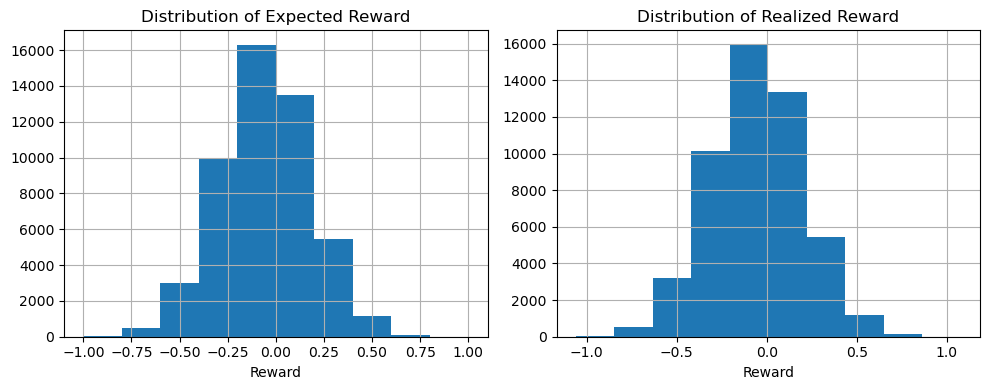

In [11]:
exp_reward = minmax(X @ true_param, bound=2*reward_bound) - reward_bound
true_reward = exp_reward + reward_noise
print(f"True reward shape: {true_reward.shape}\t First realized reward: {true_reward[0]}")

plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.hist(exp_reward)
plt.grid(True)
plt.xlabel("Reward")
plt.title("Distribution of Expected Reward")

plt.subplot(122)
plt.hist(true_reward)
plt.grid(True)
plt.xlabel("Reward")
plt.title("Distribution of Realized Reward")

plt.tight_layout()
plt.show()

In [12]:
regret_result = dict()
for alpha in ALPHAS:
    print(f"alpha={alpha}")
    regret_container = []
    for trial in range(runtime):
        agent = LinUCB(d=d, alpha=alpha)
        regrets = np.zeros(T)
        for t in tqdm_auto(range(T)):
            indices = np.random.randint(0, M, N)
            action_set, reward_set = X[indices], true_reward[indices]

            exp_rewards = action_set @ true_param
            optimal_action = np.argmax(exp_rewards)
            optimal_reward = exp_rewards[optimal_action]

            chosen_action = agent.choose(action_set)
            chosen_reward = reward_set[chosen_action]
            chosen_context = action_set[chosen_action]

            agent.update(chosen_context, chosen_reward)
            instance_regret = optimal_reward - exp_rewards[chosen_action]
            regrets[t] = instance_regret
        regret_container.append(np.cumsum(regrets))
        
    regret_result[alpha] = np.array(regret_container)

alpha=0.0


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

alpha=0.1


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

alpha=0.3


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

alpha=0.5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

alpha=1.0


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

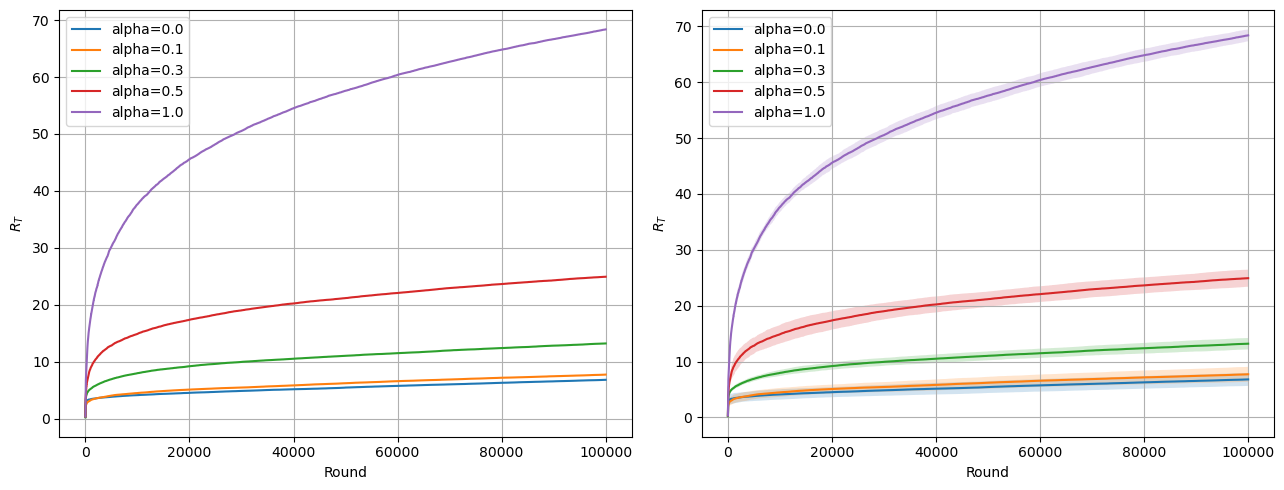

In [13]:
plt.figure(figsize=(13, 5))

plt.subplot(121)
for key, value in regret_result.items():
    mean = np.mean(value, axis=0)
    std = np.std(value, axis=0, ddof=1)
    plt.plot(mean, label=f"alpha={key}")
plt.grid(True)
plt.xlabel("Round")
plt.ylabel("$R_T$")
plt.legend()

plt.subplot(122)
for key, value in regret_result.items():
    mean = np.mean(value, axis=0)
    std = np.std(value, axis=0, ddof=1)
    plt.plot(mean, label=f"alpha={key}")
    plt.fill_between(np.arange(T), mean-std, mean+std, alpha=0.2)
plt.grid(True)
plt.xlabel("Round")
plt.ylabel("$R_T$")
plt.legend()

plt.tight_layout()
plt.show()

# $A : Z \to X, Z\in\mathbb{R}^{k}, X\in\mathbb{R}^d$ is specified

In [14]:
def run(agent:LinUCB, num_actions:int, horizon:int, obs:np.ndarray, r_exp:np.ndarray, r_true:np.ndarray, use_tqdm:bool=True, verbose:bool=False):
    action_space_size, _ = obs.shape
    assert action_space_size >= num_actions
    
    if use_tqdm:
        bar = tqdm_auto(range(horizon))
    else:
        bar = range(horizon)
    
    regrets = np.zeros(horizon)
    for t in bar:
        if action_space_size == num_actions:
            indices = np.arange(num_actions)
        else:
            indices = np.random.randint(0, action_space_size, num_actions)
        
        ## observe actions
        action_set, exp_reward_set, true_reward_set = obs[indices], r_exp[indices], r_true[indices]
        
        ## get the optimal reward and optimal action
        optimal_action = np.argmax(exp_reward_set) # index of the optimal action
        optimal_reward = exp_reward_set[optimal_action]
        
        ## choose action
        chosen_action = agent.choose(action_set)
        chosen_reward = true_reward_set[chosen_action]
        chosen_context = action_set[chosen_action]
        
        ## compute the regret
        instance_regret = optimal_reward - exp_reward_set[chosen_action]
        regrets[t] = instance_regret
        
        ## update the agent
        agent.update(chosen_context, chosen_reward)
        
        if verbose: 
            print(f"round {t+1}\toptimal action : {optimal_action}\toptimal reward : {optimal_reward:.3f}")
            print(f"\tchosen action : {chosen_arm}\trealized reward : {chosen_reward:.3f}, expected reward: {exp_reward_set[chosen_arm]:.3f}")
            print(f"\tinstance regret : {instance_regret:.3f}, cumulative regret : {np.sum(regrets):.3f}")
            
    return regrets

```python
def feature_sampler(dimension:int, feat_dist:str, size:int, disjoint:bool, cov_dist:str=None, bound:float=None)
def mapping_generator(latent_dim:int, obs_dim:int, distribution:str, bound:float=None)
def param_generator(dimension:int, distribution:str, disjoint:bool, bound:float=None)
def subgaussian_noise(distribution:str, size:int, std:float=None)
```

## $Z \sim N(0, I_k), A={(a_{ij})}_{i\in [k], j\in[d]} \sim U\left(-\sqrt{\frac{2}{k}}, \sqrt{\frac{2}{k}}\right), \mu_i\in \boldsymbol{\mu_*}\sim U(-1, 1)$

In [15]:
## latent feature
Z = feature_sampler(dimension=k, feat_dist="gaussian", size=M, disjoint=True, random_state=SEED)
Z_norms = [l2norm(Z[i, :]) for i in range(M)]

print(f"Total action space shape: {Z.shape}")
print(f"First context: {Z[0, :]}")
print(f"Maximum norm: {np.max(Z_norms)}, Minimum norm: {np.min(Z_norms)}")

Total action space shape: (50000, 7)
First context: [ 1.09077549  1.06558071  4.51574031 -0.66767452 -0.40789271  0.9866497
  0.80106522]
Maximum norm: 6.360748528852423, Minimum norm: 0.45021436593194286


In [16]:
## decoder mapping
A = mapping_generator(latent_dim=k, obs_dim=d, distribution="uniform", random_state=SEED, bound=matrix_bound)
_, sing, _ = np.linalg.svd(A)

print(f"Mapping shape: {A.shape}")
print(f"{A}")
print(f"Lower bound: {np.min(sing)}")

Mapping shape: (7, 12)
[[ 0.74878918 -0.6146192   0.27771678  0.34241084 -0.01561766  0.00544825
   0.68276717 -0.71091331  0.57663173 -0.25009199  0.87732835  0.47697374]
 [ 0.44696481  0.2547425   0.52946703 -0.90918793  0.46955461 -0.00406523
  -0.59827216  0.28118768  0.61264324  0.44618307  0.6797255  -0.20700158]
 [-0.28817115  0.68546901 -0.02505457 -0.45426654  0.18824615  0.03409485
   0.02683427  0.12114993  0.6977078   0.58655962  0.07786644  0.56840722]
 [-0.6090732  -0.70889437  0.0757958  -0.52845218 -0.10428616 -0.62182857
   0.60988066 -0.69416493 -0.07398629 -0.70547135 -0.44257926 -0.54943231]
 [-0.82785217 -0.62641188  0.87038791  0.31478371  0.31286765  0.42530421
   0.1992702  -0.56138044 -0.13475968  0.64851683  0.09369979 -0.34647581]
 [ 0.03800613 -0.60473313  0.23690548  0.1610565  -0.56998737  0.00286177
   0.4567163   0.50825623  0.59086298 -0.0786352  -0.6079819   0.00599732]
 [-0.41165617  0.34236264 -0.2458099   0.14918669 -0.77326392  0.03670672
   0.6776

### $\sigma_{\eta} = \frac{1}{\sqrt{T}}, \eta_a^i\in\boldsymbol{\eta_a} \sim N\left(0, \sigma_\eta^2\right)$

In [17]:
context_noise, std = subgaussian_noise(distribution="gaussian", size=M*d, random_state=SEED, std=1/np.sqrt(T))
context_noise = context_noise.reshape(M, d)
print(f"Shape of context noise: {context_noise.shape}")
print(f"First context noise: {context_noise[0, :]}")

Shape of context noise: (50000, 12)
First context noise: [ 0.00344933  0.00336966  0.01428002 -0.00211137 -0.00128987  0.00312006
  0.00253319  0.0032473   0.00010399  0.00358783  0.00092478 -0.00254954]


In [18]:
## Generate X
X = Z @ A + context_noise

maxnorm = np.max([l2norm(X[i, :]) for i in range(M)])
for i in range(X.shape[0]):
    X[i, :] *= (feature_bound / maxnorm)

# for i in range(M):
#     norm = l2norm(X[i, :])
#     if norm > feature_bound:
#         X[i, :] *= (feature_bound / norm)

Xnorms = [l2norm(X[i, :]) for i in range(M)]

print(f"Shape of observable features: {X.shape}")
print(f"Observable features of the first arm: {X[0, :]}")
print(f"Maximum L2 norm: {np.max(Xnorms)}\tMinimum L2 norm: {np.min(Xnorms)}")

Shape of observable features: (50000, 12)
Observable features of the first arm: [ 0.04117972  0.28599703  0.036779   -0.19758078  0.00849772  0.03983262
  0.06775981  0.10032234  0.42928792  0.23796628  0.17337749  0.2529201 ]
Maximum L2 norm: 0.9999999999999999	Minimum L2 norm: 0.06357685244634916


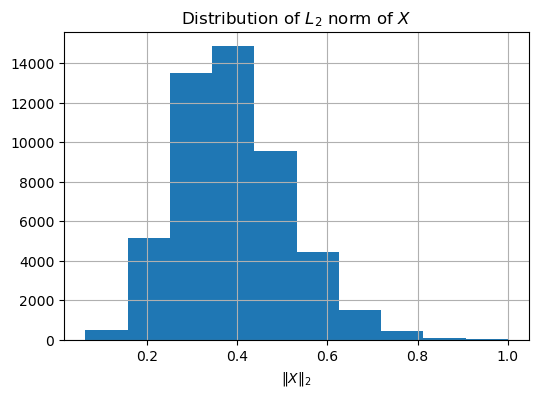

In [19]:
plt.figure(figsize=(6, 4))
plt.hist(Xnorms)
plt.grid(True)
plt.xlabel("${\Vert X \Vert}_2$")
plt.title("Distribution of $L_2$ norm of $X$")
plt.show()

### $\epsilon\sim N\left(0, \sigma_\epsilon^2\right), \sigma_\epsilon=0.1$

In [20]:
## reward parameter
true_param = param_generator(dimension=k, distribution="uniform", disjoint=True, random_state=SEED, bound=param_bound)
print(f"True reward parameter: {true_param}\tshape: {true_param.shape}\tnorm: {l2norm(true_param)}")

## reward noise
reward_noise, std = subgaussian_noise(distribution="gaussian", size=M, random_state=SEED, std=0.1)
print(f"Reward noise shape: {reward_noise.shape}, std: {std}, first noise: {reward_noise[0]}")

True reward parameter: [ 5.73974120e-01 -5.32082840e-01  2.52648026e-01  2.58621680e-01
 -5.16822360e-04  3.49546897e-03  5.06668410e-01]	shape: (7,)	norm: 1.0
Reward noise shape: (50000,), std: 0.1, first noise: 0.10907754872731577


When expected reward is bounded in [-1.0, 1.0]	 First realized reward: 0.5402266589958574
When expected reward is bounded in [0, 1.0]	 First realized reward: 0.8246521038615866


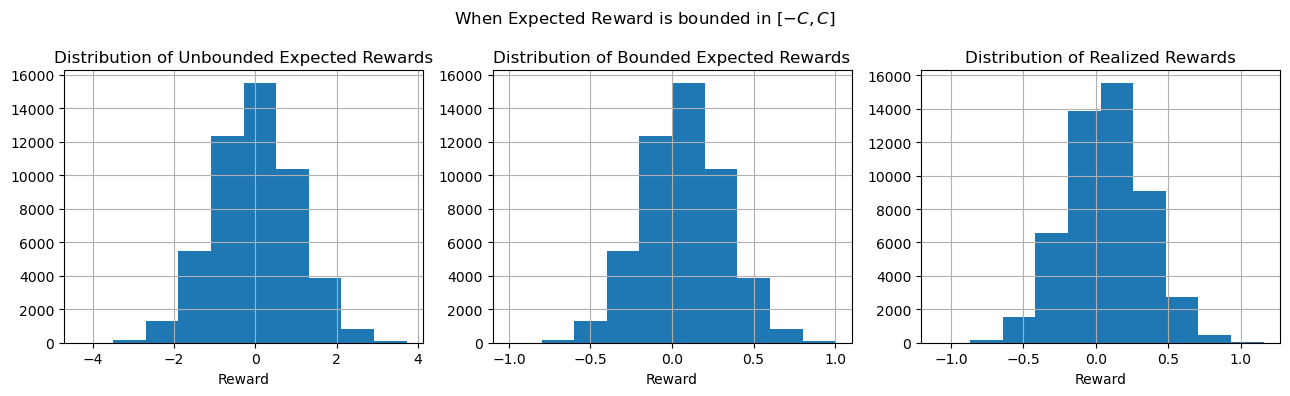

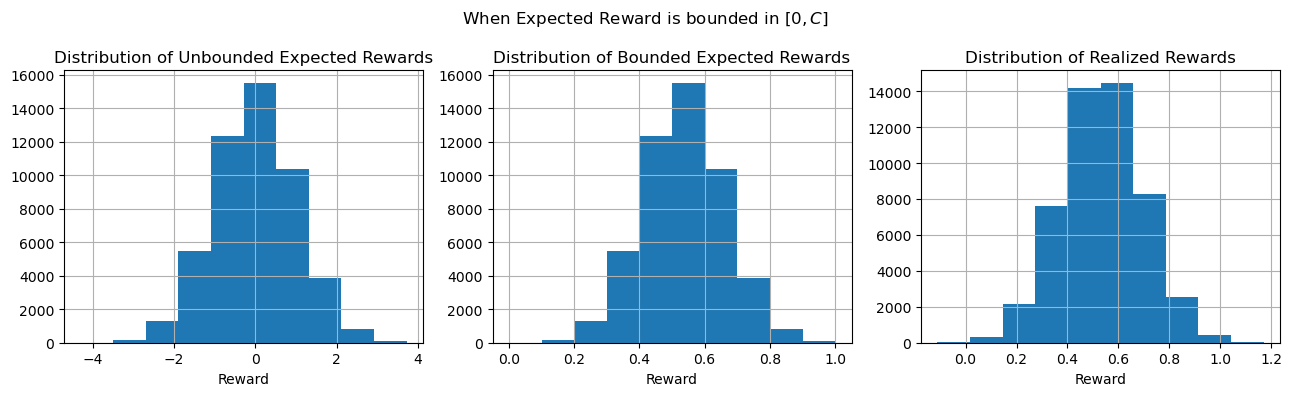

In [21]:
## reward
exp_rewards_unbounded = Z @ true_param

exp_rewards1 = minmax(Z @ true_param, bound=2*reward_bound) - reward_bound # constrain in [-C, C]
exp_rewards2 = minmax(Z @ true_param, bound=reward_bound) # constrain in [0, C]

true_rewards1 = exp_rewards1 + reward_noise
true_rewards2 = exp_rewards2 + reward_noise
print(f"When expected reward is bounded in [-{reward_bound}, {reward_bound}]\t First realized reward: {true_rewards1[0]}")
print(f"When expected reward is bounded in [0, {reward_bound}]\t First realized reward: {true_rewards2[0]}")

plt.figure(figsize=(13, 4))

plt.subplot(131)
plt.hist(exp_rewards_unbounded)
plt.grid(True)
plt.xlabel("Reward")
plt.title("Distribution of Unbounded Expected Rewards")

plt.subplot(132)
plt.hist(exp_rewards1)
plt.grid(True)
plt.xlabel("Reward")
plt.title("Distribution of Bounded Expected Rewards")

plt.subplot(133)
plt.hist(true_rewards1)
plt.grid(True)
plt.xlabel("Reward")
plt.title("Distribution of Realized Rewards")

plt.suptitle("When Expected Reward is bounded in $[-C, C]$")
plt.tight_layout()
plt.show()

plt.figure(figsize=(13, 4))

plt.subplot(131)
plt.hist(exp_rewards_unbounded)
plt.grid(True)
plt.xlabel("Reward")
plt.title("Distribution of Unbounded Expected Rewards")

plt.subplot(132)
plt.hist(exp_rewards2)
plt.grid(True)
plt.xlabel("Reward")
plt.title("Distribution of Bounded Expected Rewards")

plt.subplot(133)
plt.hist(true_rewards2)
plt.grid(True)
plt.xlabel("Reward")
plt.title("Distribution of Realized Rewards")

plt.suptitle("When Expected Reward is bounded in $[0, C]$")
plt.tight_layout()
plt.show()

In [22]:
print(f"When expected reward is bounded in [-{reward_bound}, {reward_bound}]")
result1 = dict()
for alpha in ALPHAS:
    print(f"alpha={alpha}")
    result_container = []
    for trial in range(runtime):
        agent = LinUCB(d=d, alpha=alpha)
        regret = run(agent=agent, num_actions=N, horizon=T, obs=X, r_exp=exp_rewards1, r_true=true_rewards1, use_tqdm=True)
        result_container.append(np.cumsum(regret))
    result1[alpha] = np.array(result_container)

When expected reward is bounded in [-1.0, 1.0]
alpha=0.0


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

alpha=0.1


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

alpha=0.3


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

alpha=0.5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

alpha=1.0


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

In [23]:
print(f"When expected reward is bounded in [0, {reward_bound}]")
result2 = dict()
for alpha in ALPHAS:
    print(f"alpha={alpha}")
    result_container = []
    for trial in range(runtime):
        agent = LinUCB(d=d, alpha=alpha)
        regret = run(agent=agent, num_actions=N, horizon=T, obs=X, r_exp=exp_rewards2, r_true=true_rewards2, use_tqdm=True)
        result_container.append(np.cumsum(regret))
    result2[alpha] = np.array(result_container)

When expected reward is bounded in [0, 1.0]
alpha=0.0


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

alpha=0.1


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

alpha=0.3


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

alpha=0.5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

alpha=1.0


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

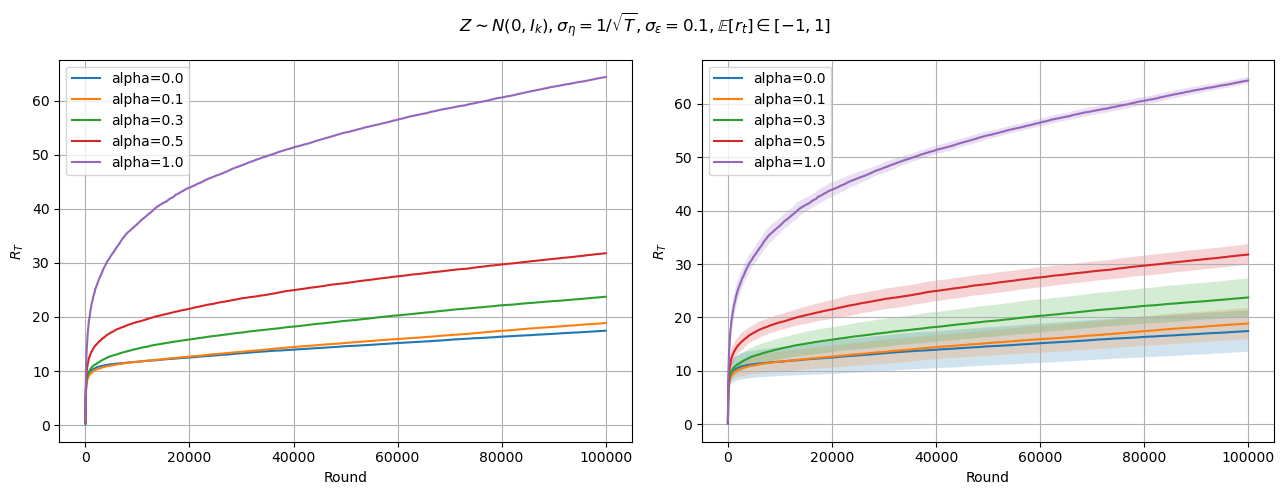

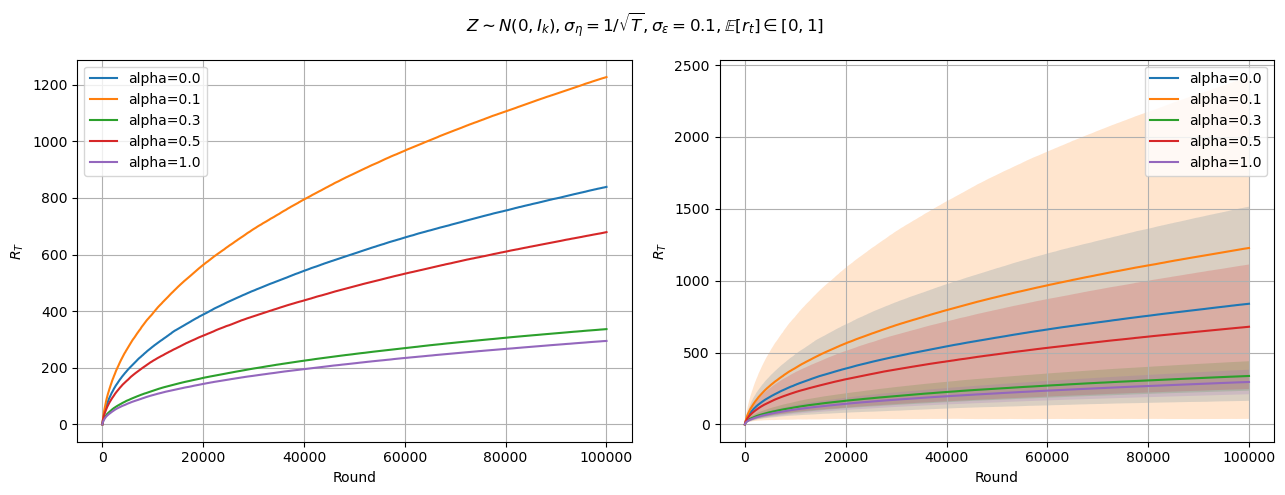

In [24]:
plt.figure(figsize=(13, 5))

plt.subplot(121)
for key, value in result1.items():
    mean = np.mean(value, axis=0)
    std = np.std(value, axis=0, ddof=1)
    plt.plot(mean, label=f"alpha={key}")
plt.grid(True)
plt.xlabel("Round")
plt.ylabel("$R_T$")
plt.legend()

plt.subplot(122)
for key, value in result1.items():
    mean = np.mean(value, axis=0)
    std = np.std(value, axis=0, ddof=1)
    plt.plot(mean, label=f"alpha={key}")
    plt.fill_between(np.arange(T), mean-std, mean+std, alpha=0.2)
plt.grid(True)
plt.xlabel("Round")
plt.ylabel("$R_T$")
plt.legend()

plt.suptitle("$Z\sim N(0, I_k), \sigma_\eta=1/\sqrt{T}, \sigma_\epsilon=0.1, \mathbb{E}[r_t]\in [-1, 1]$")
plt.tight_layout()
plt.show()

plt.figure(figsize=(13, 5))

plt.subplot(121)
for key, value in result2.items():
    mean = np.mean(value, axis=0)
    std = np.std(value, axis=0, ddof=1)
    plt.plot(mean, label=f"alpha={key}")
plt.grid(True)
plt.xlabel("Round")
plt.ylabel("$R_T$")
plt.legend()

plt.subplot(122)
for key, value in result2.items():
    mean = np.mean(value, axis=0)
    std = np.std(value, axis=0, ddof=1)
    plt.plot(mean, label=f"alpha={key}")
    plt.fill_between(np.arange(T), mean-std, mean+std, alpha=0.2)
plt.grid(True)
plt.xlabel("Round")
plt.ylabel("$R_T$")
plt.legend()

plt.suptitle("$Z\sim N(0, I_k), \sigma_\eta=1/\sqrt{T}, \sigma_\epsilon=0.1, \mathbb{E}[r_t]\in [0, 1]$")
plt.tight_layout()
plt.show()

### $\epsilon\sim N\left(0, \sigma_\epsilon^2\right), \sigma_\epsilon=0.5$

In [25]:
## reward noise
reward_noise, std = subgaussian_noise(distribution="gaussian", size=M, random_state=SEED, std=0.5)
print(f"Reward noise shape: {reward_noise.shape}, std: {std}, first noise: {reward_noise[0]}")

Reward noise shape: (50000,), std: 0.5, first noise: 0.5453877436365788


When expected reward is bounded in [-1.0, 1.0]	 First realized reward: 0.9765368539051205
When expected reward is bounded in [0, 1.0]	 First realized reward: 1.2609622987708495


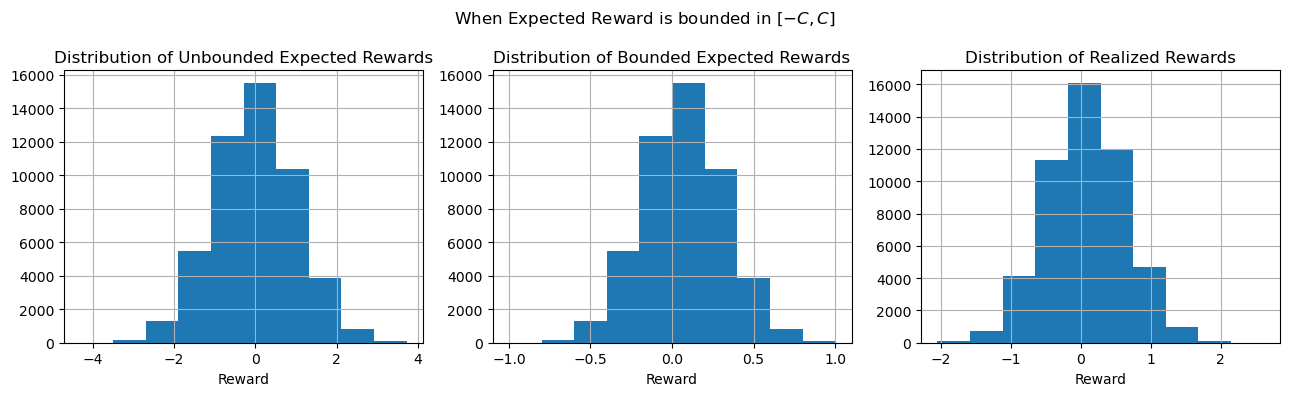

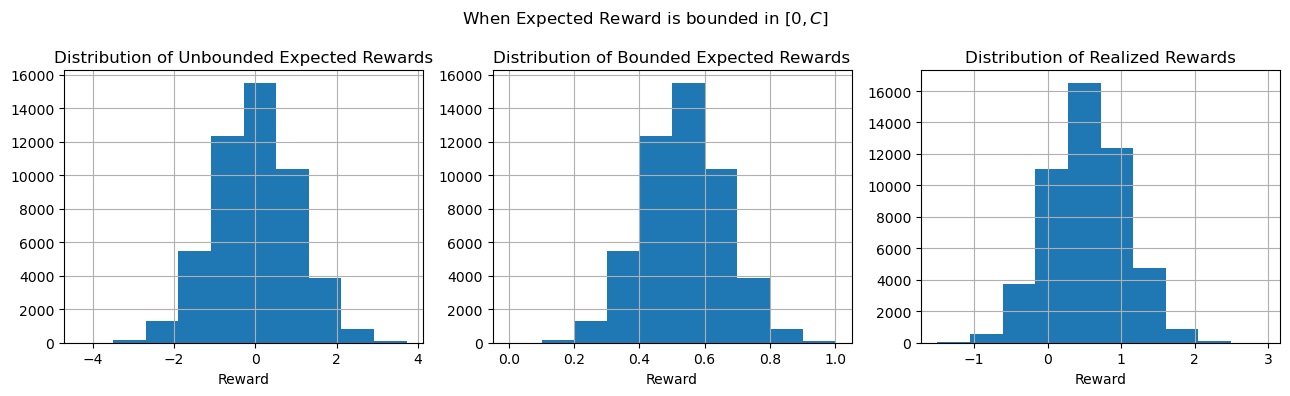

In [26]:
## reward
exp_rewards_unbounded = Z @ true_param

exp_rewards1 = minmax(Z @ true_param, bound=2*reward_bound) - reward_bound # constrain in [-C, C]
exp_rewards2 = minmax(Z @ true_param, bound=reward_bound) # constrain in [0, C]

true_rewards1 = exp_rewards1 + reward_noise
true_rewards2 = exp_rewards2 + reward_noise
print(f"When expected reward is bounded in [-{reward_bound}, {reward_bound}]\t First realized reward: {true_rewards1[0]}")
print(f"When expected reward is bounded in [0, {reward_bound}]\t First realized reward: {true_rewards2[0]}")

plt.figure(figsize=(13, 4))

plt.subplot(131)
plt.hist(exp_rewards_unbounded)
plt.grid(True)
plt.xlabel("Reward")
plt.title("Distribution of Unbounded Expected Rewards")

plt.subplot(132)
plt.hist(exp_rewards1)
plt.grid(True)
plt.xlabel("Reward")
plt.title("Distribution of Bounded Expected Rewards")

plt.subplot(133)
plt.hist(true_rewards1)
plt.grid(True)
plt.xlabel("Reward")
plt.title("Distribution of Realized Rewards")

plt.suptitle("When Expected Reward is bounded in $[-C, C]$")
plt.tight_layout()
plt.show()

plt.figure(figsize=(13, 4))

plt.subplot(131)
plt.hist(exp_rewards_unbounded)
plt.grid(True)
plt.xlabel("Reward")
plt.title("Distribution of Unbounded Expected Rewards")

plt.subplot(132)
plt.hist(exp_rewards2)
plt.grid(True)
plt.xlabel("Reward")
plt.title("Distribution of Bounded Expected Rewards")

plt.subplot(133)
plt.hist(true_rewards2)
plt.grid(True)
plt.xlabel("Reward")
plt.title("Distribution of Realized Rewards")

plt.suptitle("When Expected Reward is bounded in $[0, C]$")
plt.tight_layout()
plt.show()

In [27]:
print(f"When expected reward is bounded in [-{reward_bound}, {reward_bound}]")
result1 = dict()
for alpha in ALPHAS:
    print(f"alpha={alpha}")
    result_container = []
    for trial in range(runtime):
        agent = LinUCB(d=d, alpha=alpha)
        regret = run(agent=agent, num_actions=N, horizon=T, obs=X, r_exp=exp_rewards1, r_true=true_rewards1, use_tqdm=True)
        result_container.append(np.cumsum(regret))
    result1[alpha] = np.array(result_container)

When expected reward is bounded in [-1.0, 1.0]
alpha=0.0


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

alpha=0.1


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

alpha=0.3


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

alpha=0.5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

alpha=1.0


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

In [28]:
print(f"When expected reward is bounded in [0, {reward_bound}]")
result2 = dict()
for alpha in ALPHAS:
    print(f"alpha={alpha}")
    result_container = []
    for trial in range(runtime):
        agent = LinUCB(d=d, alpha=alpha)
        regret = run(agent=agent, num_actions=N, horizon=T, obs=X, r_exp=exp_rewards2, r_true=true_rewards2, use_tqdm=True)
        result_container.append(np.cumsum(regret))
    result2[alpha] = np.array(result_container)

When expected reward is bounded in [0, 1.0]
alpha=0.0


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

alpha=0.1


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

alpha=0.3


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

alpha=0.5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

alpha=1.0


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

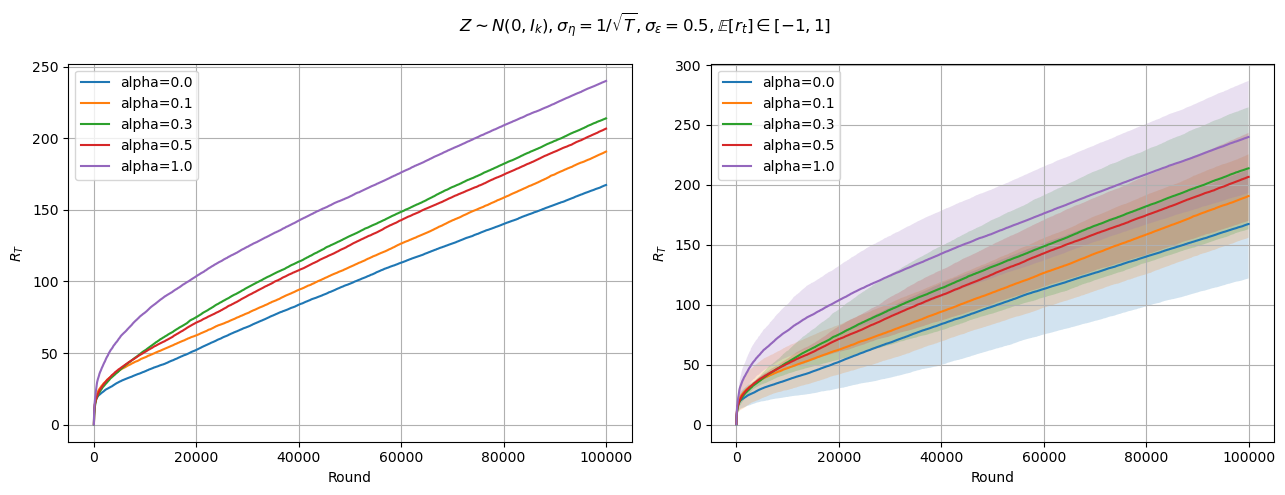

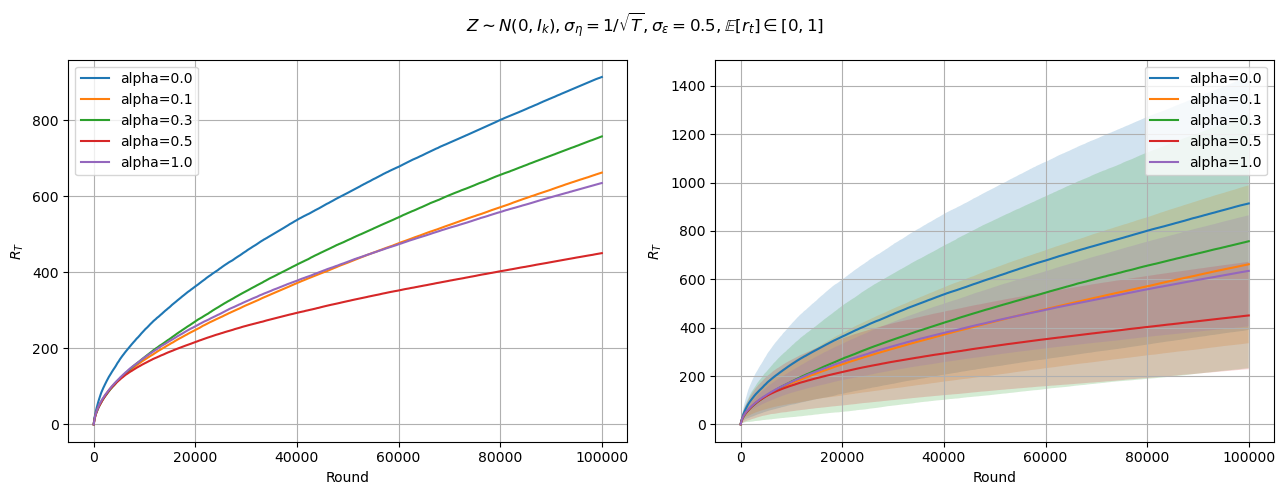

In [30]:
plt.figure(figsize=(13, 5))

plt.subplot(121)
for key, value in result1.items():
    mean = np.mean(value, axis=0)
    std = np.std(value, axis=0, ddof=1)
    plt.plot(mean, label=f"alpha={key}")
plt.grid(True)
plt.xlabel("Round")
plt.ylabel("$R_T$")
plt.legend()

plt.subplot(122)
for key, value in result1.items():
    mean = np.mean(value, axis=0)
    std = np.std(value, axis=0, ddof=1)
    plt.plot(mean, label=f"alpha={key}")
    plt.fill_between(np.arange(T), mean-std, mean+std, alpha=0.2)
plt.grid(True)
plt.xlabel("Round")
plt.ylabel("$R_T$")
plt.legend()

plt.suptitle("$Z\sim N(0, I_k), \sigma_\eta=1/\sqrt{T}, \sigma_\epsilon=0.5, \mathbb{E}[r_t]\in [-1, 1]$")
plt.tight_layout()
plt.show()

plt.figure(figsize=(13, 5))

plt.subplot(121)
for key, value in result2.items():
    mean = np.mean(value, axis=0)
    std = np.std(value, axis=0, ddof=1)
    plt.plot(mean, label=f"alpha={key}")
plt.grid(True)
plt.xlabel("Round")
plt.ylabel("$R_T$")
plt.legend()

plt.subplot(122)
for key, value in result2.items():
    mean = np.mean(value, axis=0)
    std = np.std(value, axis=0, ddof=1)
    plt.plot(mean, label=f"alpha={key}")
    plt.fill_between(np.arange(T), mean-std, mean+std, alpha=0.2)
plt.grid(True)
plt.xlabel("Round")
plt.ylabel("$R_T$")
plt.legend()

plt.suptitle("$Z\sim N(0, I_k), \sigma_\eta=1/\sqrt{T}, \sigma_\epsilon=0.5, \mathbb{E}[r_t]\in [0, 1]$")
plt.tight_layout()
plt.show()

### $\sigma_{\eta} = \frac{1}{T}, \eta_a^i\in\boldsymbol{\eta_a} \sim N\left(0, \sigma_\eta^2\right)$

In [31]:
context_noise, std = subgaussian_noise(distribution="gaussian", size=M*d, random_state=SEED, std=1/T)
context_noise = context_noise.reshape(M, d)
print(f"Shape of context noise: {context_noise.shape}")
print(f"First context noise: {context_noise[0, :]}")

Shape of context noise: (50000, 12)
First context noise: [ 1.09077549e-05  1.06558071e-05  4.51574031e-05 -6.67674518e-06
 -4.07892714e-06  9.86649701e-06  8.01065216e-06  1.02688747e-05
  3.28845957e-07  1.13457120e-05  2.92441406e-06 -8.06235461e-06]


In [32]:
## Generate X
X = Z @ A + context_noise

maxnorm = np.max([l2norm(X[i, :]) for i in range(M)])
for i in range(X.shape[0]):
    X[i, :] *= (feature_bound / maxnorm)

# for i in range(M):
#     norm = l2norm(X[i, :])
#     if norm > feature_bound:
#         X[i, :] *= (feature_bound / norm)

Xnorms = [l2norm(X[i, :]) for i in range(M)]

print(f"Shape of observable features: {X.shape}")
print(f"Observable features of the first arm: {X[0, :]}")
print(f"Maximum L2 norm: {np.max(Xnorms)}\tMinimum L2 norm: {np.min(Xnorms)}")

Shape of observable features: (50000, 12)
Observable features of the first arm: [ 0.0408709   0.28574208  0.03547511 -0.19742453  0.00861774  0.03955378
  0.06754015  0.10004332  0.42935999  0.23768217  0.17332556  0.25320223]
Maximum L2 norm: 1.0	Minimum L2 norm: 0.06335577285447362


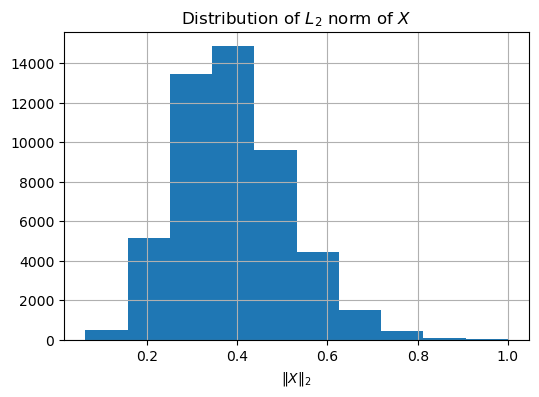

In [33]:
plt.figure(figsize=(6, 4))
plt.hist(Xnorms)
plt.grid(True)
plt.xlabel("${\Vert X \Vert}_2$")
plt.title("Distribution of $L_2$ norm of $X$")
plt.show()

### $\epsilon\sim N\left(0, \sigma_\epsilon^2\right), \sigma_\epsilon=0.1$

In [34]:
## reward parameter
# true_param = param_generator(dimension=k, distribution="uniform", disjoint=True, random_state=SEED, bound=param_bound)
print(f"True reward parameter: {true_param}\tshape: {true_param.shape}\tnorm: {l2norm(true_param)}")

## reward noise
reward_noise, std = subgaussian_noise(distribution="gaussian", size=M, random_state=SEED, std=0.1)
print(f"Reward noise shape: {reward_noise.shape}, std: {std}, first noise: {reward_noise[0]}")

True reward parameter: [ 5.73974120e-01 -5.32082840e-01  2.52648026e-01  2.58621680e-01
 -5.16822360e-04  3.49546897e-03  5.06668410e-01]	shape: (7,)	norm: 1.0
Reward noise shape: (50000,), std: 0.1, first noise: 0.10907754872731577


When expected reward is bounded in [-1.0, 1.0]	 First realized reward: 0.5402266589958574
When expected reward is bounded in [0, 1.0]	 First realized reward: 0.8246521038615866


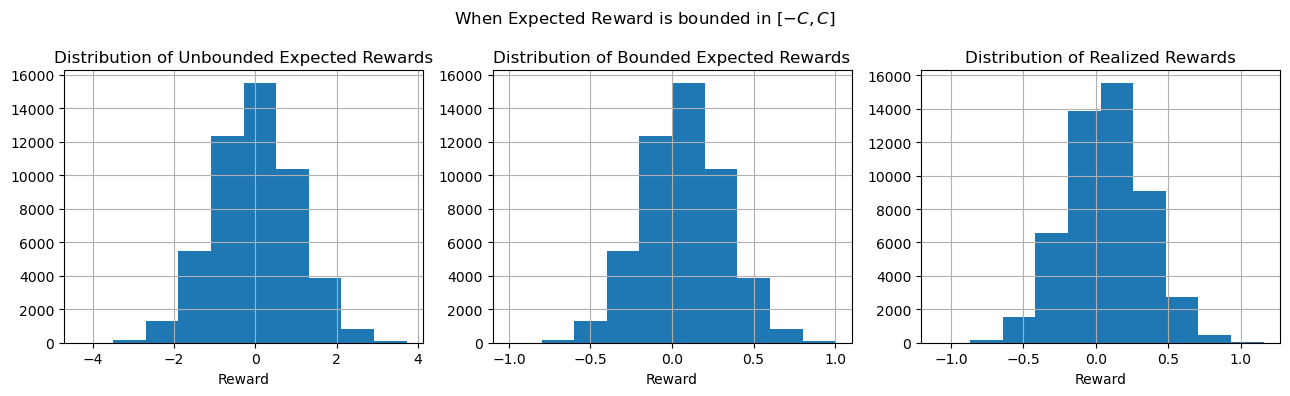

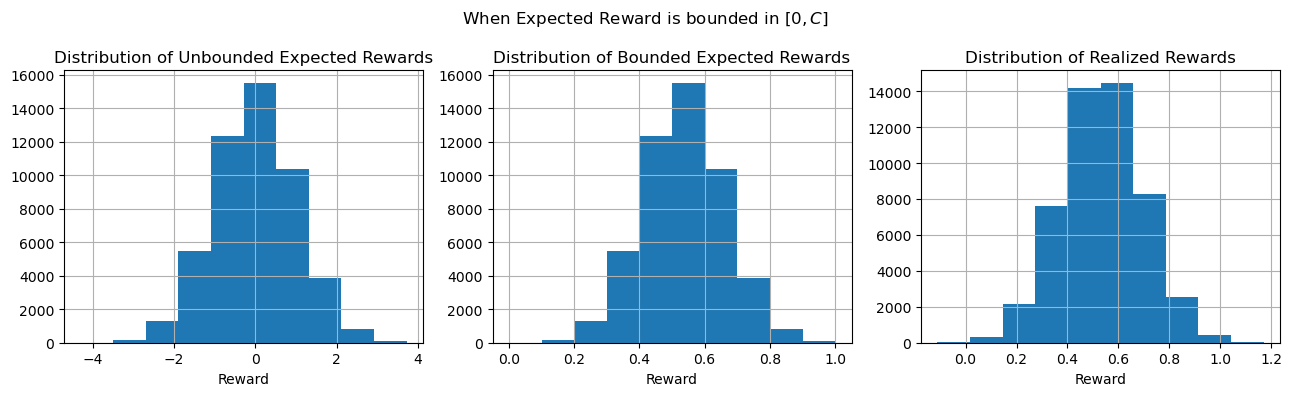

In [35]:
## reward
exp_rewards_unbounded = Z @ true_param

exp_rewards1 = minmax(Z @ true_param, bound=2*reward_bound) - reward_bound # constrain in [-C, C]
exp_rewards2 = minmax(Z @ true_param, bound=reward_bound) # constrain in [0, C]

true_rewards1 = exp_rewards1 + reward_noise
true_rewards2 = exp_rewards2 + reward_noise
print(f"When expected reward is bounded in [-{reward_bound}, {reward_bound}]\t First realized reward: {true_rewards1[0]}")
print(f"When expected reward is bounded in [0, {reward_bound}]\t First realized reward: {true_rewards2[0]}")

plt.figure(figsize=(13, 4))

plt.subplot(131)
plt.hist(exp_rewards_unbounded)
plt.grid(True)
plt.xlabel("Reward")
plt.title("Distribution of Unbounded Expected Rewards")

plt.subplot(132)
plt.hist(exp_rewards1)
plt.grid(True)
plt.xlabel("Reward")
plt.title("Distribution of Bounded Expected Rewards")

plt.subplot(133)
plt.hist(true_rewards1)
plt.grid(True)
plt.xlabel("Reward")
plt.title("Distribution of Realized Rewards")

plt.suptitle("When Expected Reward is bounded in $[-C, C]$")
plt.tight_layout()
plt.show()

plt.figure(figsize=(13, 4))

plt.subplot(131)
plt.hist(exp_rewards_unbounded)
plt.grid(True)
plt.xlabel("Reward")
plt.title("Distribution of Unbounded Expected Rewards")

plt.subplot(132)
plt.hist(exp_rewards2)
plt.grid(True)
plt.xlabel("Reward")
plt.title("Distribution of Bounded Expected Rewards")

plt.subplot(133)
plt.hist(true_rewards2)
plt.grid(True)
plt.xlabel("Reward")
plt.title("Distribution of Realized Rewards")

plt.suptitle("When Expected Reward is bounded in $[0, C]$")
plt.tight_layout()
plt.show()

In [36]:
print(f"When expected reward is bounded in [-{reward_bound}, {reward_bound}]")
result1 = dict()
for alpha in ALPHAS:
    print(f"alpha={alpha}")
    result_container = []
    for trial in range(runtime):
        agent = LinUCB(d=d, alpha=alpha)
        regret = run(agent=agent, num_actions=N, horizon=T, obs=X, r_exp=exp_rewards1, r_true=true_rewards1, use_tqdm=True)
        result_container.append(np.cumsum(regret))
    result1[alpha] = np.array(result_container)

When expected reward is bounded in [-1.0, 1.0]
alpha=0.0


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

alpha=0.1


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

alpha=0.3


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

alpha=0.5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

alpha=1.0


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

In [37]:
print(f"When expected reward is bounded in [0, {reward_bound}]")
result2 = dict()
for alpha in ALPHAS:
    print(f"alpha={alpha}")
    result_container = []
    for trial in range(runtime):
        agent = LinUCB(d=d, alpha=alpha)
        regret = run(agent=agent, num_actions=N, horizon=T, obs=X, r_exp=exp_rewards2, r_true=true_rewards2, use_tqdm=True)
        result_container.append(np.cumsum(regret))
    result2[alpha] = np.array(result_container)

When expected reward is bounded in [0, 1.0]
alpha=0.0


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

alpha=0.1


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

alpha=0.3


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

alpha=0.5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

alpha=1.0


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

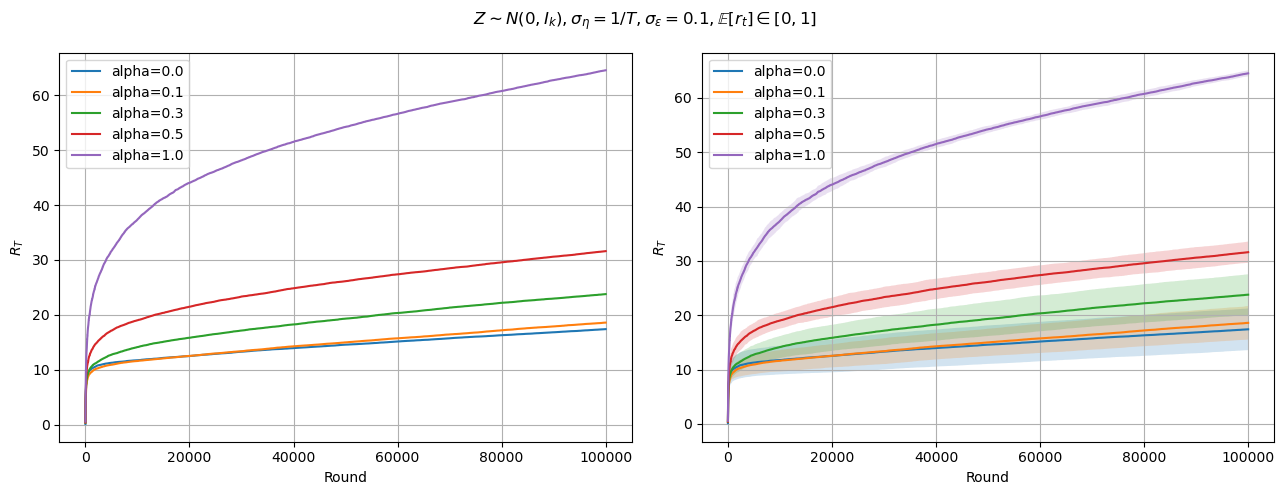

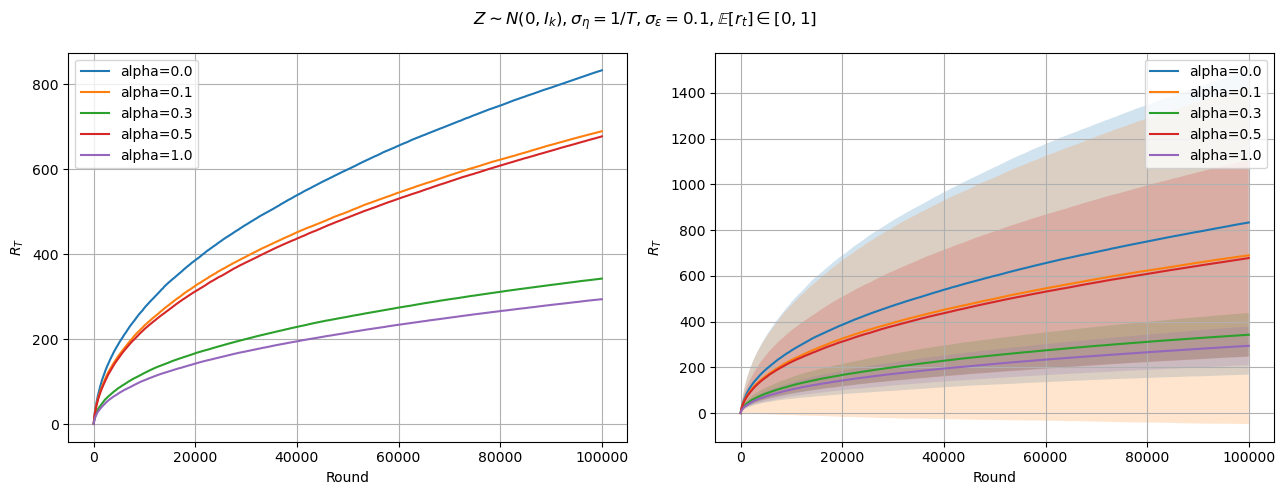

In [38]:
plt.figure(figsize=(13, 5))

plt.subplot(121)
for key, value in result1.items():
    mean = np.mean(value, axis=0)
    std = np.std(value, axis=0, ddof=1)
    plt.plot(mean, label=f"alpha={key}")
plt.grid(True)
plt.xlabel("Round")
plt.ylabel("$R_T$")
plt.legend()

plt.subplot(122)
for key, value in result1.items():
    mean = np.mean(value, axis=0)
    std = np.std(value, axis=0, ddof=1)
    plt.plot(mean, label=f"alpha={key}")
    plt.fill_between(np.arange(T), mean-std, mean+std, alpha=0.2)
plt.grid(True)
plt.xlabel("Round")
plt.ylabel("$R_T$")
plt.legend()

plt.suptitle("$Z\sim N(0, I_k), \sigma_\eta=1/T, \sigma_\epsilon=0.1, \mathbb{E}[r_t]\in [0, 1]$")
plt.tight_layout()
plt.show()

plt.figure(figsize=(13, 5))

plt.subplot(121)
for key, value in result2.items():
    mean = np.mean(value, axis=0)
    std = np.std(value, axis=0, ddof=1)
    plt.plot(mean, label=f"alpha={key}")
plt.grid(True)
plt.xlabel("Round")
plt.ylabel("$R_T$")
plt.legend()

plt.subplot(122)
for key, value in result2.items():
    mean = np.mean(value, axis=0)
    std = np.std(value, axis=0, ddof=1)
    plt.plot(mean, label=f"alpha={key}")
    plt.fill_between(np.arange(T), mean-std, mean+std, alpha=0.2)
plt.grid(True)
plt.xlabel("Round")
plt.ylabel("$R_T$")
plt.legend()

plt.suptitle("$Z\sim N(0, I_k), \sigma_\eta=1/T, \sigma_\epsilon=0.1, \mathbb{E}[r_t]\in [0, 1]$")
plt.tight_layout()
plt.show()

### $\epsilon\sim N\left(0, \sigma_\epsilon^2\right), \sigma_\epsilon=0.5$

In [39]:
## reward noise
reward_noise, std = subgaussian_noise(distribution="gaussian", size=M, random_state=SEED, std=0.5)
print(f"Reward noise shape: {reward_noise.shape}, std: {std}, first noise: {reward_noise[0]}")

Reward noise shape: (50000,), std: 0.5, first noise: 0.5453877436365788


When expected reward is bounded in [-1.0, 1.0]	 First realized reward: 0.9765368539051205
When expected reward is bounded in [0, 1.0]	 First realized reward: 1.2609622987708495


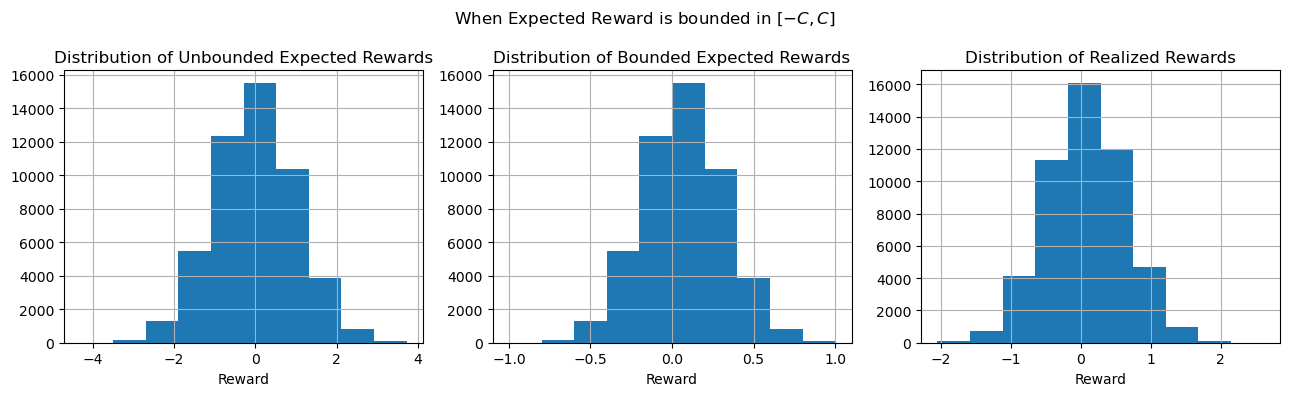

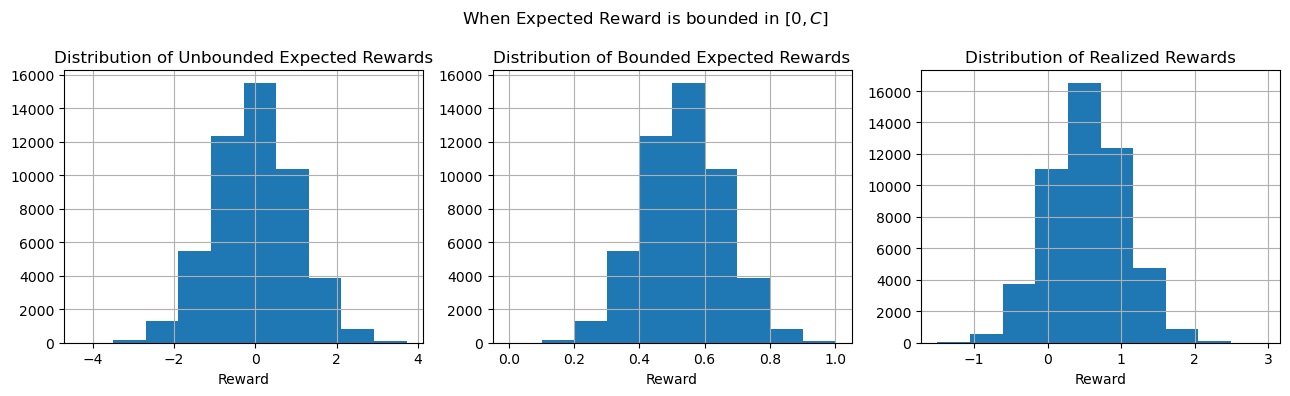

In [40]:
## reward
exp_rewards_unbounded = Z @ true_param

exp_rewards1 = minmax(Z @ true_param, bound=2*reward_bound) - reward_bound # constrain in [-C, C]
exp_rewards2 = minmax(Z @ true_param, bound=reward_bound) # constrain in [0, C]

true_rewards1 = exp_rewards1 + reward_noise
true_rewards2 = exp_rewards2 + reward_noise
print(f"When expected reward is bounded in [-{reward_bound}, {reward_bound}]\t First realized reward: {true_rewards1[0]}")
print(f"When expected reward is bounded in [0, {reward_bound}]\t First realized reward: {true_rewards2[0]}")

plt.figure(figsize=(13, 4))

plt.subplot(131)
plt.hist(exp_rewards_unbounded)
plt.grid(True)
plt.xlabel("Reward")
plt.title("Distribution of Unbounded Expected Rewards")

plt.subplot(132)
plt.hist(exp_rewards1)
plt.grid(True)
plt.xlabel("Reward")
plt.title("Distribution of Bounded Expected Rewards")

plt.subplot(133)
plt.hist(true_rewards1)
plt.grid(True)
plt.xlabel("Reward")
plt.title("Distribution of Realized Rewards")

plt.suptitle("When Expected Reward is bounded in $[-C, C]$")
plt.tight_layout()
plt.show()

plt.figure(figsize=(13, 4))

plt.subplot(131)
plt.hist(exp_rewards_unbounded)
plt.grid(True)
plt.xlabel("Reward")
plt.title("Distribution of Unbounded Expected Rewards")

plt.subplot(132)
plt.hist(exp_rewards2)
plt.grid(True)
plt.xlabel("Reward")
plt.title("Distribution of Bounded Expected Rewards")

plt.subplot(133)
plt.hist(true_rewards2)
plt.grid(True)
plt.xlabel("Reward")
plt.title("Distribution of Realized Rewards")

plt.suptitle("When Expected Reward is bounded in $[0, C]$")
plt.tight_layout()
plt.show()

In [41]:
print(f"When expected reward is bounded in [-{reward_bound}, {reward_bound}]")
result1 = dict()
for alpha in ALPHAS:
    print(f"alpha={alpha}")
    result_container = []
    for trial in range(runtime):
        agent = LinUCB(d=d, alpha=alpha)
        regret = run(agent=agent, num_actions=N, horizon=T, obs=X, r_exp=exp_rewards1, r_true=true_rewards1, use_tqdm=True)
        result_container.append(np.cumsum(regret))
    result1[alpha] = np.array(result_container)

When expected reward is bounded in [-1.0, 1.0]
alpha=0.0


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

alpha=0.1


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

alpha=0.3


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

alpha=0.5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

alpha=1.0


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

In [42]:
print(f"When expected reward is bounded in [0, {reward_bound}]")
result2 = dict()
for alpha in ALPHAS:
    print(f"alpha={alpha}")
    result_container = []
    for trial in range(runtime):
        agent = LinUCB(d=d, alpha=alpha)
        regret = run(agent=agent, num_actions=N, horizon=T, obs=X, r_exp=exp_rewards2, r_true=true_rewards2, use_tqdm=True)
        result_container.append(np.cumsum(regret))
    result2[alpha] = np.array(result_container)

When expected reward is bounded in [0, 1.0]
alpha=0.0


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

alpha=0.1


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

alpha=0.3


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

alpha=0.5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

alpha=1.0


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

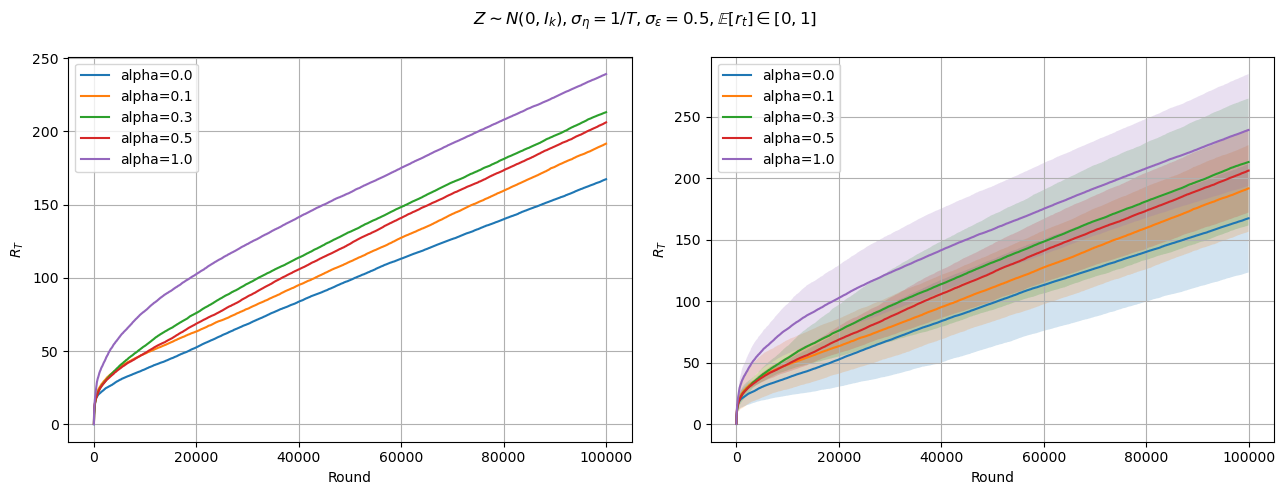

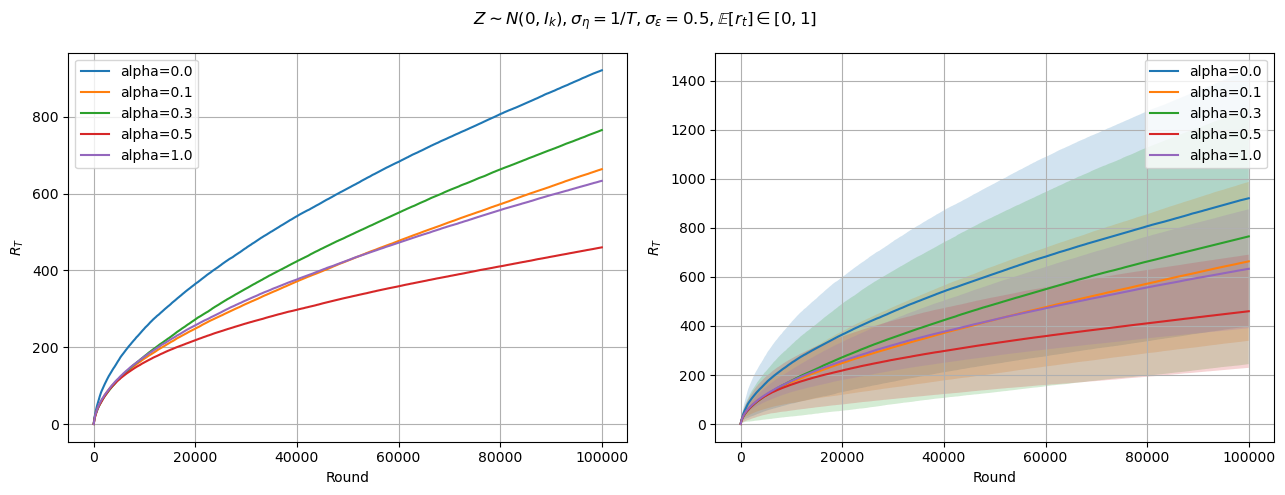

In [43]:
plt.figure(figsize=(13, 5))

plt.subplot(121)
for key, value in result1.items():
    mean = np.mean(value, axis=0)
    std = np.std(value, axis=0, ddof=1)
    plt.plot(mean, label=f"alpha={key}")
plt.grid(True)
plt.xlabel("Round")
plt.ylabel("$R_T$")
plt.legend()

plt.subplot(122)
for key, value in result1.items():
    mean = np.mean(value, axis=0)
    std = np.std(value, axis=0, ddof=1)
    plt.plot(mean, label=f"alpha={key}")
    plt.fill_between(np.arange(T), mean-std, mean+std, alpha=0.2)
plt.grid(True)
plt.xlabel("Round")
plt.ylabel("$R_T$")
plt.legend()

plt.suptitle("$Z\sim N(0, I_k), \sigma_\eta=1/T, \sigma_\epsilon=0.5, \mathbb{E}[r_t]\in [0, 1]$")
plt.tight_layout()
plt.show()

plt.figure(figsize=(13, 5))

plt.subplot(121)
for key, value in result2.items():
    mean = np.mean(value, axis=0)
    std = np.std(value, axis=0, ddof=1)
    plt.plot(mean, label=f"alpha={key}")
plt.grid(True)
plt.xlabel("Round")
plt.ylabel("$R_T$")
plt.legend()

plt.subplot(122)
for key, value in result2.items():
    mean = np.mean(value, axis=0)
    std = np.std(value, axis=0, ddof=1)
    plt.plot(mean, label=f"alpha={key}")
    plt.fill_between(np.arange(T), mean-std, mean+std, alpha=0.2)
plt.grid(True)
plt.xlabel("Round")
plt.ylabel("$R_T$")
plt.legend()

plt.suptitle("$Z\sim N(0, I_k), \sigma_\eta=1/T, \sigma_\epsilon=0.5, \mathbb{E}[r_t]\in [0, 1]$")
plt.tight_layout()
plt.show()

### $\sigma_{\eta} = 1, \eta_a^i\in\boldsymbol{\eta_a} \sim N\left(0, \sigma_\eta^2\right)$

In [44]:
context_noise, std = subgaussian_noise(distribution="gaussian", size=M*d, random_state=SEED, std=1)
context_noise = context_noise.reshape(M, d)
print(f"Shape of context noise: {context_noise.shape}")
print(f"First context noise: {context_noise[0, :]}")

Shape of context noise: (50000, 12)
First context noise: [ 1.09077549  1.06558071  4.51574031 -0.66767452 -0.40789271  0.9866497
  0.80106522  1.02688747  0.0328846   1.1345712   0.29244141 -0.80623546]


In [45]:
## Generate X
X = Z @ A + context_noise

maxnorm = np.max([l2norm(X[i, :]) for i in range(M)])
for i in range(X.shape[0]):
    X[i, :] *= (feature_bound / maxnorm)

# for i in range(M):
#     norm = l2norm(X[i, :])
#     if norm > feature_bound:
#         X[i, :] *= (feature_bound / norm)

Xnorms = [l2norm(X[i, :]) for i in range(M)]

print(f"Shape of observable features: {X.shape}")
print(f"Observable features of the first arm: {X[0, :]}")
print(f"Maximum L2 norm: {np.max(Xnorms)}\tMinimum L2 norm: {np.min(Xnorms)}")

Shape of observable features: (50000, 12)
Observable features of the first arm: [ 0.12129367  0.32947413  0.38737    -0.22222126 -0.02484307  0.11193313
  0.1212852   0.16703141  0.37111696  0.29367749  0.17187898  0.1535979 ]
Maximum L2 norm: 1.0	Minimum L2 norm: 0.11061515640409257


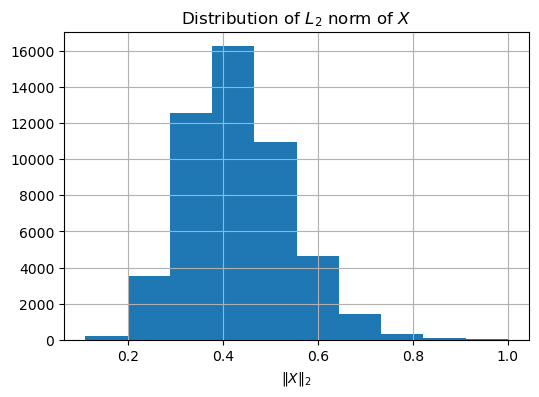

In [46]:
plt.figure(figsize=(6, 4))
plt.hist(Xnorms)
plt.grid(True)
plt.xlabel("${\Vert X \Vert}_2$")
plt.title("Distribution of $L_2$ norm of $X$")
plt.show()

### $\epsilon\sim N\left(0, \sigma_\epsilon^2\right), \sigma_\epsilon=0.1$

In [47]:
## reward parameter
# true_param = param_generator(dimension=k, distribution="uniform", disjoint=True, random_state=SEED, bound=param_bound)
print(f"True reward parameter: {true_param}\tshape: {true_param.shape}\tnorm: {l2norm(true_param)}")

## reward noise
reward_noise, std = subgaussian_noise(distribution="gaussian", size=M, random_state=SEED, std=0.1)
print(f"Reward noise shape: {reward_noise.shape}, std: {std}, first noise: {reward_noise[0]}")

True reward parameter: [ 5.73974120e-01 -5.32082840e-01  2.52648026e-01  2.58621680e-01
 -5.16822360e-04  3.49546897e-03  5.06668410e-01]	shape: (7,)	norm: 1.0
Reward noise shape: (50000,), std: 0.1, first noise: 0.10907754872731577


When expected reward is bounded in [-1.0, 1.0]	 First realized reward: 0.5402266589958574
When expected reward is bounded in [0, 1.0]	 First realized reward: 0.8246521038615866


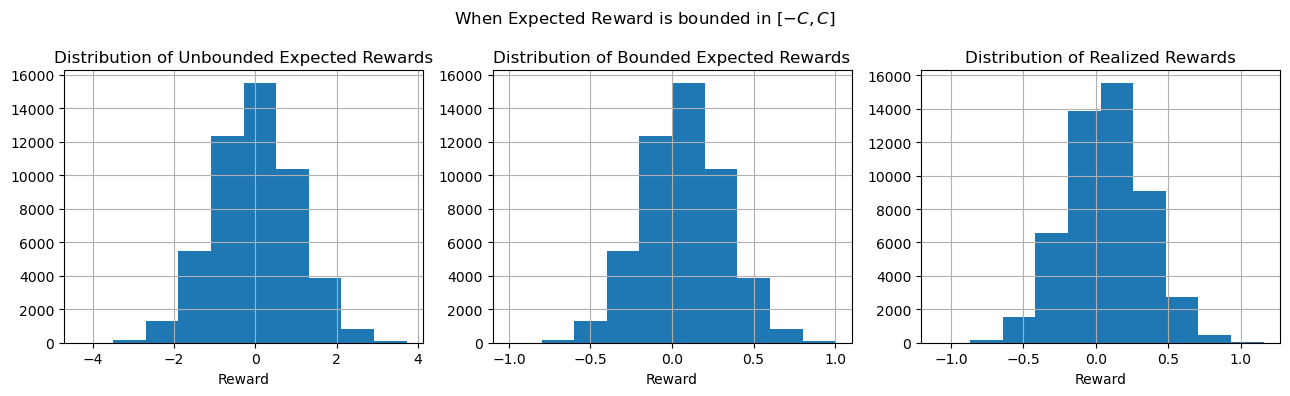

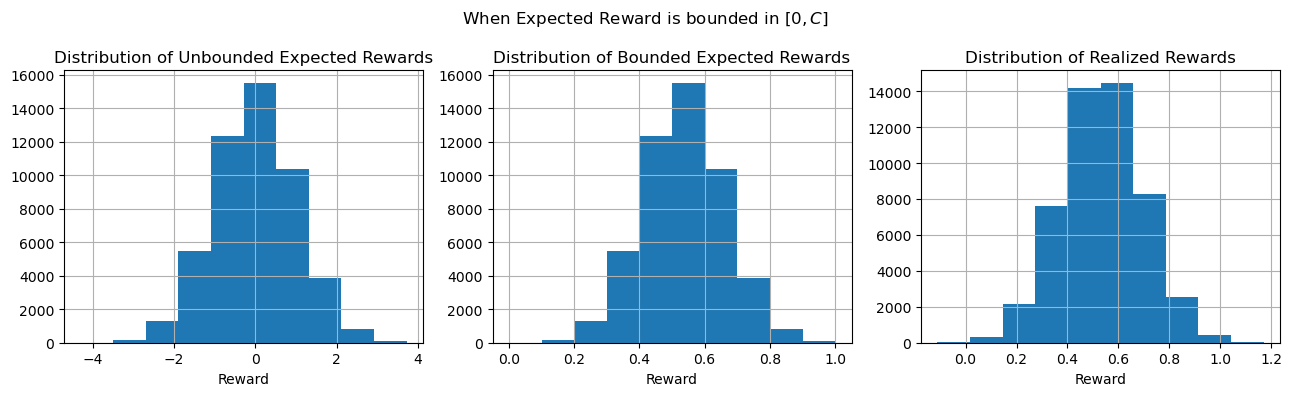

In [48]:
## reward
exp_rewards_unbounded = Z @ true_param

exp_rewards1 = minmax(Z @ true_param, bound=2*reward_bound) - reward_bound # constrain in [-C, C]
exp_rewards2 = minmax(Z @ true_param, bound=reward_bound) # constrain in [0, C]

true_rewards1 = exp_rewards1 + reward_noise
true_rewards2 = exp_rewards2 + reward_noise
print(f"When expected reward is bounded in [-{reward_bound}, {reward_bound}]\t First realized reward: {true_rewards1[0]}")
print(f"When expected reward is bounded in [0, {reward_bound}]\t First realized reward: {true_rewards2[0]}")

plt.figure(figsize=(13, 4))

plt.subplot(131)
plt.hist(exp_rewards_unbounded)
plt.grid(True)
plt.xlabel("Reward")
plt.title("Distribution of Unbounded Expected Rewards")

plt.subplot(132)
plt.hist(exp_rewards1)
plt.grid(True)
plt.xlabel("Reward")
plt.title("Distribution of Bounded Expected Rewards")

plt.subplot(133)
plt.hist(true_rewards1)
plt.grid(True)
plt.xlabel("Reward")
plt.title("Distribution of Realized Rewards")

plt.suptitle("When Expected Reward is bounded in $[-C, C]$")
plt.tight_layout()
plt.show()

plt.figure(figsize=(13, 4))

plt.subplot(131)
plt.hist(exp_rewards_unbounded)
plt.grid(True)
plt.xlabel("Reward")
plt.title("Distribution of Unbounded Expected Rewards")

plt.subplot(132)
plt.hist(exp_rewards2)
plt.grid(True)
plt.xlabel("Reward")
plt.title("Distribution of Bounded Expected Rewards")

plt.subplot(133)
plt.hist(true_rewards2)
plt.grid(True)
plt.xlabel("Reward")
plt.title("Distribution of Realized Rewards")

plt.suptitle("When Expected Reward is bounded in $[0, C]$")
plt.tight_layout()
plt.show()

In [50]:
print(f"When expected reward is bounded in [-{reward_bound}, {reward_bound}]")
result1 = dict()
for alpha in ALPHAS:
    print(f"alpha={alpha}")
    result_container = []
    for trial in range(runtime):
        agent = LinUCB(d=d, alpha=alpha)
        regret = run(agent=agent, num_actions=N, horizon=T, obs=X, r_exp=exp_rewards1, r_true=true_rewards1, use_tqdm=True)
        result_container.append(np.cumsum(regret))
    result1[alpha] = np.array(result_container)

When expected reward is bounded in [-1.0, 1.0]
alpha=0.0


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

alpha=0.1


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

alpha=0.3


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

alpha=0.5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

alpha=1.0


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

In [51]:
print(f"When expected reward is bounded in [0, {reward_bound}]")
result2 = dict()
for alpha in ALPHAS:
    print(f"alpha={alpha}")
    result_container = []
    for trial in range(runtime):
        agent = LinUCB(d=d, alpha=alpha)
        regret = run(agent=agent, num_actions=N, horizon=T, obs=X, r_exp=exp_rewards2, r_true=true_rewards2, use_tqdm=True)
        result_container.append(np.cumsum(regret))
    result2[alpha] = np.array(result_container)

When expected reward is bounded in [0, 1.0]
alpha=0.0


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

alpha=0.1


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

alpha=0.3


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

alpha=0.5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

alpha=1.0


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

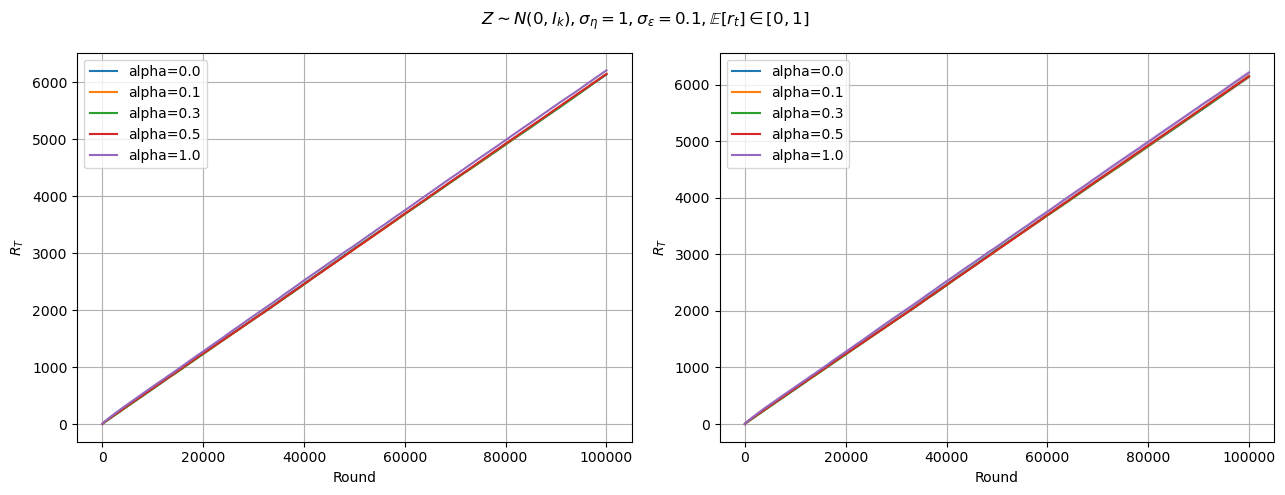

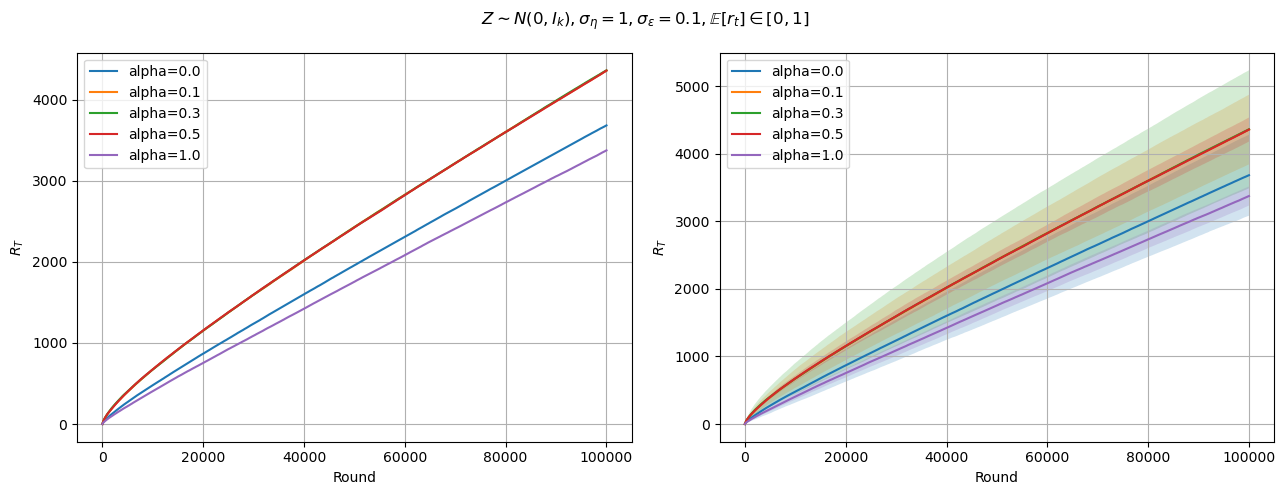

In [52]:
plt.figure(figsize=(13, 5))

plt.subplot(121)
for key, value in result1.items():
    mean = np.mean(value, axis=0)
    std = np.std(value, axis=0, ddof=1)
    plt.plot(mean, label=f"alpha={key}")
plt.grid(True)
plt.xlabel("Round")
plt.ylabel("$R_T$")
plt.legend()

plt.subplot(122)
for key, value in result1.items():
    mean = np.mean(value, axis=0)
    std = np.std(value, axis=0, ddof=1)
    plt.plot(mean, label=f"alpha={key}")
    plt.fill_between(np.arange(T), mean-std, mean+std, alpha=0.2)
plt.grid(True)
plt.xlabel("Round")
plt.ylabel("$R_T$")
plt.legend()

plt.suptitle("$Z\sim N(0, I_k), \sigma_\eta=1, \sigma_\epsilon=0.1, \mathbb{E}[r_t]\in [0, 1]$")
plt.tight_layout()
plt.show()

plt.figure(figsize=(13, 5))

plt.subplot(121)
for key, value in result2.items():
    mean = np.mean(value, axis=0)
    std = np.std(value, axis=0, ddof=1)
    plt.plot(mean, label=f"alpha={key}")
plt.grid(True)
plt.xlabel("Round")
plt.ylabel("$R_T$")
plt.legend()

plt.subplot(122)
for key, value in result2.items():
    mean = np.mean(value, axis=0)
    std = np.std(value, axis=0, ddof=1)
    plt.plot(mean, label=f"alpha={key}")
    plt.fill_between(np.arange(T), mean-std, mean+std, alpha=0.2)
plt.grid(True)
plt.xlabel("Round")
plt.ylabel("$R_T$")
plt.legend()

plt.suptitle("$Z\sim N(0, I_k), \sigma_\eta=1, \sigma_\epsilon=0.1, \mathbb{E}[r_t]\in [0, 1]$")
plt.tight_layout()
plt.show()

### $\epsilon\sim N\left(0, \sigma_\epsilon^2\right), \sigma_\epsilon=0.5$

In [53]:
## reward noise
reward_noise, std = subgaussian_noise(distribution="gaussian", size=M, random_state=SEED, std=0.5)
print(f"Reward noise shape: {reward_noise.shape}, std: {std}, first noise: {reward_noise[0]}")

Reward noise shape: (50000,), std: 0.5, first noise: 0.5453877436365788


When expected reward is bounded in [-1.0, 1.0]	 First realized reward: 0.9765368539051205
When expected reward is bounded in [0, 1.0]	 First realized reward: 1.2609622987708495


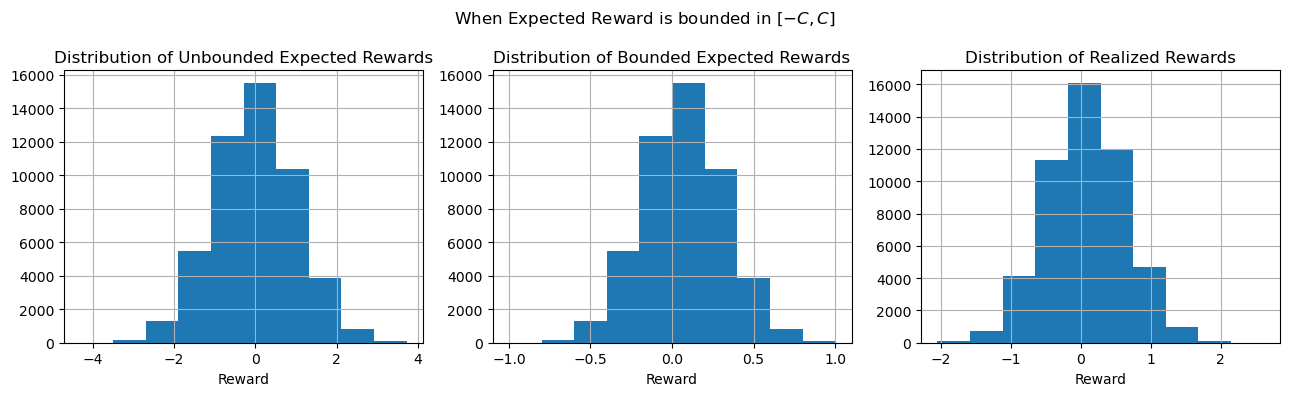

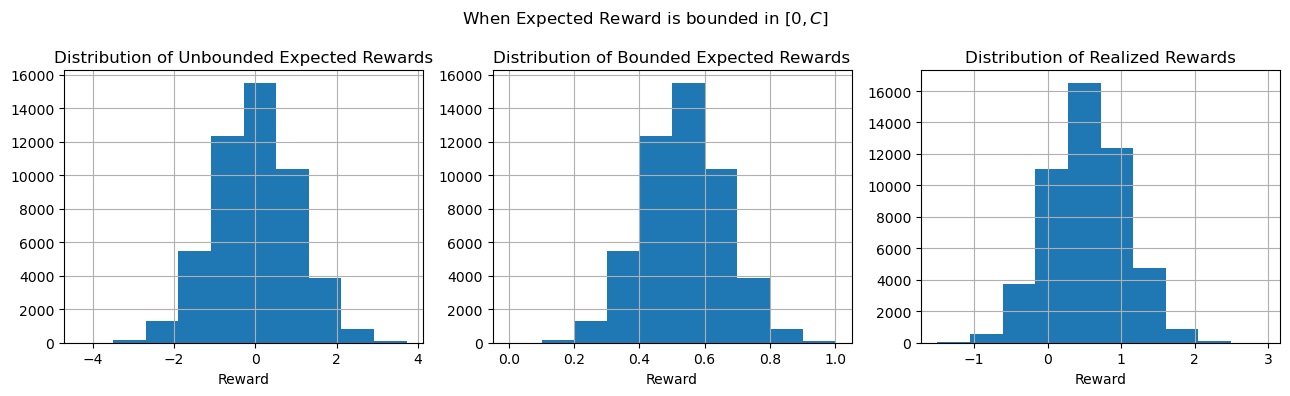

In [54]:
## reward
exp_rewards_unbounded = Z @ true_param

exp_rewards1 = minmax(Z @ true_param, bound=2*reward_bound) - reward_bound # constrain in [-C, C]
exp_rewards2 = minmax(Z @ true_param, bound=reward_bound) # constrain in [0, C]

true_rewards1 = exp_rewards1 + reward_noise
true_rewards2 = exp_rewards2 + reward_noise
print(f"When expected reward is bounded in [-{reward_bound}, {reward_bound}]\t First realized reward: {true_rewards1[0]}")
print(f"When expected reward is bounded in [0, {reward_bound}]\t First realized reward: {true_rewards2[0]}")

plt.figure(figsize=(13, 4))

plt.subplot(131)
plt.hist(exp_rewards_unbounded)
plt.grid(True)
plt.xlabel("Reward")
plt.title("Distribution of Unbounded Expected Rewards")

plt.subplot(132)
plt.hist(exp_rewards1)
plt.grid(True)
plt.xlabel("Reward")
plt.title("Distribution of Bounded Expected Rewards")

plt.subplot(133)
plt.hist(true_rewards1)
plt.grid(True)
plt.xlabel("Reward")
plt.title("Distribution of Realized Rewards")

plt.suptitle("When Expected Reward is bounded in $[-C, C]$")
plt.tight_layout()
plt.show()

plt.figure(figsize=(13, 4))

plt.subplot(131)
plt.hist(exp_rewards_unbounded)
plt.grid(True)
plt.xlabel("Reward")
plt.title("Distribution of Unbounded Expected Rewards")

plt.subplot(132)
plt.hist(exp_rewards2)
plt.grid(True)
plt.xlabel("Reward")
plt.title("Distribution of Bounded Expected Rewards")

plt.subplot(133)
plt.hist(true_rewards2)
plt.grid(True)
plt.xlabel("Reward")
plt.title("Distribution of Realized Rewards")

plt.suptitle("When Expected Reward is bounded in $[0, C]$")
plt.tight_layout()
plt.show()

In [55]:
print(f"When expected reward is bounded in [-{reward_bound}, {reward_bound}]")
result1 = dict()
for alpha in ALPHAS:
    print(f"alpha={alpha}")
    result_container = []
    for trial in range(runtime):
        agent = LinUCB(d=d, alpha=alpha)
        regret = run(agent=agent, num_actions=N, horizon=T, obs=X, r_exp=exp_rewards1, r_true=true_rewards1, use_tqdm=True)
        result_container.append(np.cumsum(regret))
    result1[alpha] = np.array(result_container)

When expected reward is bounded in [-1.0, 1.0]
alpha=0.0


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

alpha=0.1


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

alpha=0.3


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

alpha=0.5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

alpha=1.0


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

In [56]:
print(f"When expected reward is bounded in [0, {reward_bound}]")
result2 = dict()
for alpha in ALPHAS:
    print(f"alpha={alpha}")
    result_container = []
    for trial in range(runtime):
        agent = LinUCB(d=d, alpha=alpha)
        regret = run(agent=agent, num_actions=N, horizon=T, obs=X, r_exp=exp_rewards2, r_true=true_rewards2, use_tqdm=True)
        result_container.append(np.cumsum(regret))
    result2[alpha] = np.array(result_container)

When expected reward is bounded in [0, 1.0]
alpha=0.0


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

alpha=0.1


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

alpha=0.3


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

alpha=0.5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

alpha=1.0


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

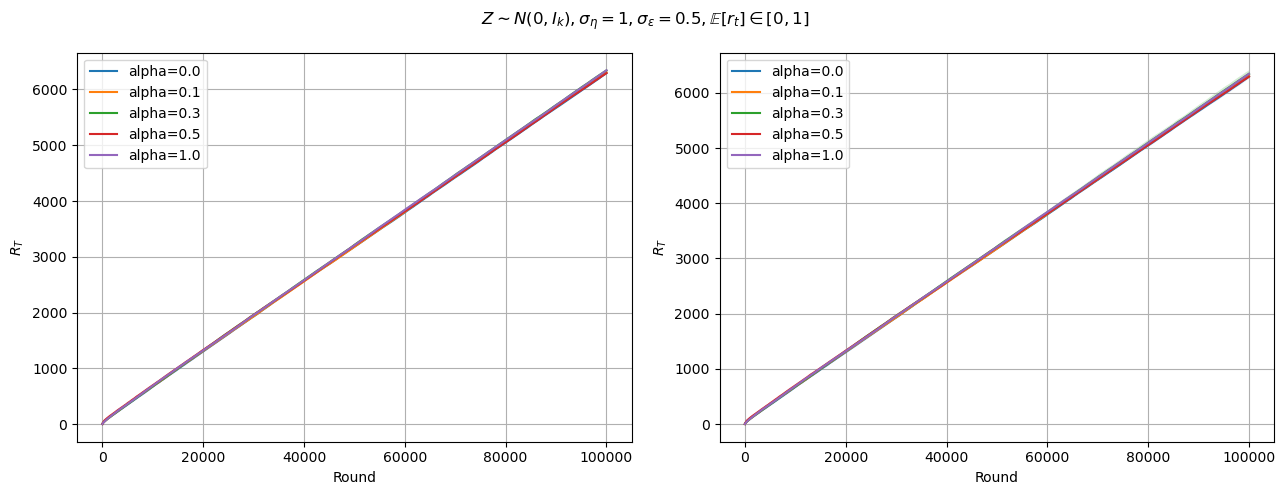

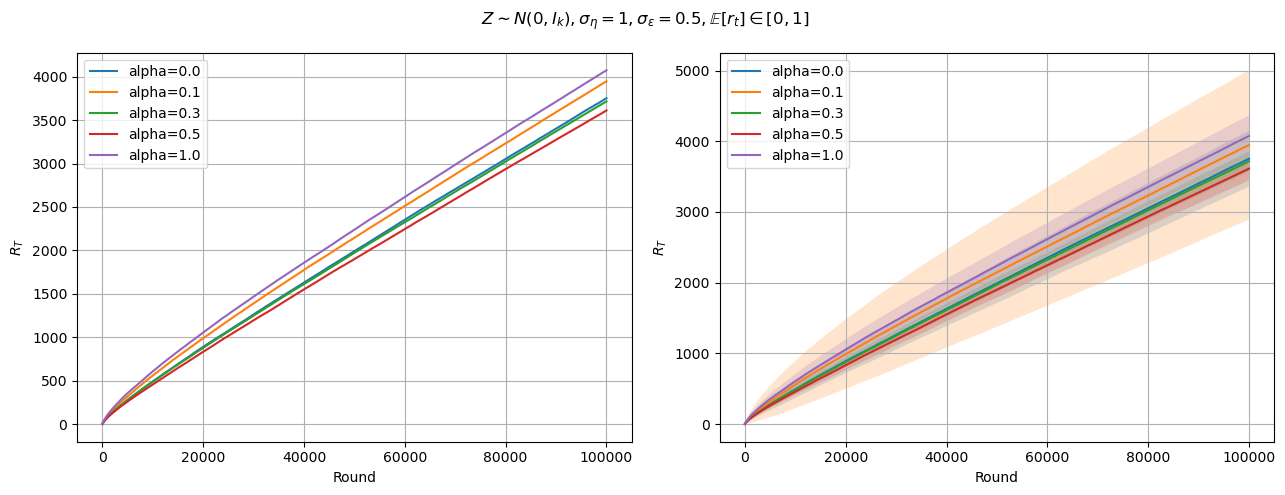

In [57]:
plt.figure(figsize=(13, 5))

plt.subplot(121)
for key, value in result1.items():
    mean = np.mean(value, axis=0)
    std = np.std(value, axis=0, ddof=1)
    plt.plot(mean, label=f"alpha={key}")
plt.grid(True)
plt.xlabel("Round")
plt.ylabel("$R_T$")
plt.legend()

plt.subplot(122)
for key, value in result1.items():
    mean = np.mean(value, axis=0)
    std = np.std(value, axis=0, ddof=1)
    plt.plot(mean, label=f"alpha={key}")
    plt.fill_between(np.arange(T), mean-std, mean+std, alpha=0.2)
plt.grid(True)
plt.xlabel("Round")
plt.ylabel("$R_T$")
plt.legend()

plt.suptitle("$Z\sim N(0, I_k), \sigma_\eta=1, \sigma_\epsilon=0.5, \mathbb{E}[r_t]\in [0, 1]$")
plt.tight_layout()
plt.show()

plt.figure(figsize=(13, 5))

plt.subplot(121)
for key, value in result2.items():
    mean = np.mean(value, axis=0)
    std = np.std(value, axis=0, ddof=1)
    plt.plot(mean, label=f"alpha={key}")
plt.grid(True)
plt.xlabel("Round")
plt.ylabel("$R_T$")
plt.legend()

plt.subplot(122)
for key, value in result2.items():
    mean = np.mean(value, axis=0)
    std = np.std(value, axis=0, ddof=1)
    plt.plot(mean, label=f"alpha={key}")
    plt.fill_between(np.arange(T), mean-std, mean+std, alpha=0.2)
plt.grid(True)
plt.xlabel("Round")
plt.ylabel("$R_T$")
plt.legend()

plt.suptitle("$Z\sim N(0, I_k), \sigma_\eta=1, \sigma_\epsilon=0.5, \mathbb{E}[r_t]\in [0, 1]$")
plt.tight_layout()
plt.show()